# Der Bayes-Filter am Beispiel des Trackings eines Roboterfahrzeugs
7.1.2019, S. Mack

**Der Kalman-Filter ist eine Untergruppe der g-h-Filter und gehört zu den *Bayes-Filtern*.**  
Wikipedia definiert Bayes-Filter wie folgt: "Der Bayessche Filter oder Bayes-Filter ist ein rekursives, probabilistisches Verfahren zur Schätzung von Wahrscheinlichkeitsverteilungen unbeobachteter Zustände eines Systems bei gegeben Beobachtungen und Messungen."  

Wie beim bisher schon behandelten g-h-Filter geht es also um *Schätzungen* von *Zustandswerten* aufgrund von *Messungen* mit Hilfe eines *rekursiven = iterativen* Verfahrens. Neu am Bayes-Filter ist die *Wahrscheinlichkeitsrechnung*.  

Wie schon in den voran gegangenen Notebooks erwähnt, orientiert sich die kommende Erklärung der Bayes-Filter am Jupyter-Notebook von R. Labbe. R. Labbe wiederum bezieht sich auf frühere Arbeiten von Dieter Fox und Sebastian Thrun, siehe [1], [2] sowie [3].  

Der Bayes-Filter wird hier anwendungsorientier über Gedankenexperimente eingeführt und nicht wie leider in vielen Lehrbüchern zuerst mathematisch hergeleitet. Die grundlegende Mathematik wird kurs am Ende dieses Notebooks behandelt.

## Grundideen zum Tracking des Roboterfahrzeugs entlang eines Flurs

<img src="RoboFahrzeugParallelTuerenFlur.png" width="800">

Wie in der Skizze oben dargestellt, fährt das Roboterfahrzeug parallel zur Wand eines langen schmalen Flurs. Auf einer Seite des Flurs gehen in gleichen Abständen insgesamt zehn Türen ab, welche mit 0...9 von Links nach Rechts durchnummeriert sind.  
Jetzt geht es nicht mehr darum, dass das Fahrzeug mithilfe seines Abstandssensors parallel zur Wand fährt. Dieses Problem sei gelöst.  
Das Fahrzeug kann jetzt vorwärts oder Rückwärts fahren und ist innerhalb einer Sekunde zur nächsten Türe gefahren. Es hat zusätzliche Sensoren: Diese erfassen einmal pro Sekunde folgende Zustandswerte:  
* Bewegung des Fahrzeugs: Vorwärts (links) zur nächsten Türe, Rückwärts (rechts) zur nächsten Türe oder Stillstand.
* Zustand Türe an Position des Fahrzeug: Offene Türe (Sensorwert 1) oder geschlossene Türe (Sensorwert 0).

Das Fahrzeug fährt immer den Flur entlang, egal ob eine Türe geöffnet ist oder nicht. Beispielsweise folgt es einer Linie auf dem Flurboden mit Hilfe eines Liniensensors.  
Eine mögliche Abfolge von Sensordaten sind folgende:  

Sample | Bewegung | Türe | Wert Türsensor
--- | --- | --- | ---
1 | links | offen | 1
2 | links | geschlossen | 0
3 | links | geschlossen | 0
4 | rechts | geschlossen | 0
5 | rechts | offen | 1
6 | still | offen | 1
... | ... | ... | ...


**Die Aufgabe des Bayes-Filters ist es, mit Hilfer dieser Sensordaten die Position des Fahrzeugs im Flur zu schätzen, also vorherzusagen, vor welcher Tür sich das Fahrzeug gerade befindet**  
Dies geht aber nur mit zusätzlichem Wissen darüber, welche Türe im Flur geöffnet ist und welche nicht. Diess Information ist im NumPy-Array ``hallway`` abgelegt. Eine 1 steht für eine offene und eine 0 für eine geschlossene Türe.

Zu Beginn liegt keine Information zur Position des Fahrzeugs im Flur vor. Es gibt zehn Türen, also zehn mögliche Positionen. Mangels Anfangsinformationen muss also angenommen werden, dass sich das Fahrzeug mit gleicher Wahrscheinlichkeit vor jeder der Türen befinden kann: Die Wahrscheinlichkeit für jede Türposition beträgt also 1/10.  
Diese Positionsannahme wird in Form von Wahrscheinlichkeitsdichten über den NumPy-Array ``belief`` repräsentiert: Dem Index 0 dieses Arrays ist die Türe 0, dem Index 1 die Türe 1, dem Index 2 die Türe 2 usw. zugeordnet.

In [1]:
import numpy as np
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0]) # 1 stands for open door at this index position
belief = np.array([1./10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


**In der Bayes-Statistik wird die Positionsannahme ``belief`` als "Prior" oder "A-Priori-Wahrscheinlichkeitsdichte" bezeichnet. Es ist die Wahrscheinlichkeit *bevor* neue Messdaten oder andere Informationen für eine Korrektur mit einbezogen werden**  
In diesem Wahrscheinlichkeitsdichte-Array kommen als Indizes alle möglichen Zustände des Systems vor. Daher muss die Quersumme des Arrays auch Eins ergeben, denn einen dieser vielen Zustände muss das System tatsächlich besitzen.  

Die Bayes-Statistik ist ein Zweig der allgemeinen mathematischen Statistik.  
Die klassische Statistik im Gegensatz zur Bayes-Statistik setzt unendlich oft wiederholbaren Zufallsexperimente voraus. Ein promimentes Beispiel hierfür ist das Würfeln: Wenn man unendlich oft würfelt, dann wird man z.B. im Mittel genau 3,5 Augen erreichen oder zu genau 1/6 Einsen gewürfelt haben.  
Für die Bayes-Statistik bedeutet "Wahrscheinlichkeit" im Gegensatz dazu nicht "Häufigkeit" sondern "Annahme" (engl. Belief), dass ein bestimmter Zustand vorliegt, ohne dies beweisen zu können.  
Die klassische Wahrscheinlichkeit macht keine Annahme über den Ausgang eines konkreten "Würfelereignisses". Die Bayes-Statistik hingegen zieht Informationen aus der Vergangenheit (den Prior) mit heran und *macht* eine Annahme darüber, welche Augenzahl am wahrscheinlichsten für den gerade geworfenen Würfel ist. Bei einem ungezinkten Würfel wirkt sich die Vergangenheit natürlich nicht aus. Daher ist hier die Bayes-Statistik auf Fehl am Platz.  
Anders ist das z.B. bei der Wettervorhersage: Hier ist auch viel Statistik im Spiel, und das Wetter morgen hängt stark vom Wetter heute ab.  
Zurück zum Roboterfahrzeug: Auch für das Fahrzeug ist die Wahrscheinlichkeit für eine bestimmte Türposition abhängig von der Vergangenheit, denn das Fahrzeug kann pro Sekunde maximal um eine Türe weiter fahren. 

### Exemplarisches Beispiel: Türmessdaten zur Konkretisierung der Positionsannahme

Weiter geht es mit dem Gedankenexperiment: Zunächst werden nur die Messdaten bezüglich der Türen (offen oder geschlossen) verwendet. Die Startposition des Fahrzeugs sei nicht bekannt.  
Die erste Messung ergibt den Messwert "Türe geschlossen". Mit dieser Information zusammen mit dem NumPy-Array ``hallway`` mit den Positionen der geöffneten Türen lässt sich eine Annahme zur Position des Fahrzeugs berechnen: Es gibt nur drei geöffnete Türen an den Positionen 0,1 und 8. Folglich ist die Wahrscheinlichkeitsdichte der Fahrzeugposition an jeder dieser drei Positionen gleich 1/3. Die Wahrscheinlichkeitsdichte quantifiziert die Annahme über die Fahrzeugposition.  

Das folgenden Histogramm visualisiert diese Wahrscheinlichkeitsdichteverteilung.

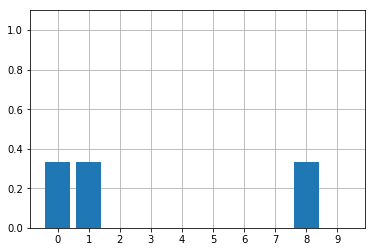

In [2]:
# display plots inside this notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

def barPlot(belief_data, y_lim=1.1):
    plt.grid(zorder=0)
    plt.ylim(0,y_lim)
    x = np.arange(len(belief_data))
    plt.xticks(x)
    plt.bar(x, belief_data, color='C0',zorder=3) # zorder to have bars in front of grid
            
belief = np.array([1./3, 1./3, 0, 0, 0, 0, 0, 0, 1/3, 0])
plt.figure()
barPlot(belief)

Diese Verteilung beschreib die Wahrscheinlichkeiten für die zehn verschiedenen Positionszustände des Fahrzeugs. Es ist eine *mulitmodale* Wahrscheinlichkeitsverteilung, denn es gibt drei gleichwahrscheinliche Annahmen über die mögliche Position: Türe 0, 1 oder 8. Die drei entsprechenden Balken im Histogramm sind gleich hoch.    
Die Bayessche Annahme ist, dass das Fahrzeug mit einer Wahrscheinlichkeit von 33,3 % vor der Türe 0, 33,3 % vor Türe 1 und 33,3 % vor Türe 8 steht.  

Die Annahme vor der Messung war noch 10 % für jede Türe. Durch die Messung ist die neue Annahme also konkreter geworden - Wahrscheinlichkeiten von einigen Türpositionen sind auf Kosten der anderen Türpositionen größer geworden. Das Wissen über den tatsächlichen Zustand ist damit angewachsen.  

Die Variable `belief` für die Annahme vor der Messung wurde oben per Hand codiert. Die neue Annahme kann nun über die Variable `hallway` wie folgt berechnet werden:

In [3]:
belief = hallway * (1./3)
print(belief)

[0.33333333 0.33333333 0.         0.         0.         0.
 0.         0.         0.33333333 0.        ]


### Exemplarisches Beispiel: Fusion von Tür- und Bewegungsmessdaten zur Konkretisierung der Positionsannahme

Im voran gegangenen Abschnitt wurde nur eine einmalige Türmessung betrachtet. Nun sollen zwei aufeinander folgende Türmessungen und die dazwischen liegende Bewegungsmessung berücksichtigt werden. Angenommen die Messwerte habe folgende Abfolge:

  * Türsensor: Türe offen
  * Bewegungssensor: Bewegung nach Rechts
  * Türsensor: Türe offen

Kann damit die Position des Fahrzeugs bestimmt werden? Klar! Denn es gibt nur zwei offene und zugleich benachbarte Türen - die Türen 0 und 1. Also muss der Roboter bei Türe 0 gestartet sein und sich aktuell vor der Türe 1 befinden.  
Alle anderen möglichen Startpositionen stehen im Widerspruch zu den Messdaten.

Die hieraus resultierende Annahme zur Position des Roboter ist wie folgt als Wahrscheinlichkeitsdichte ausgedrückt:

In [4]:
belief = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

Das Muster der geöffnenten Türen war in diesem Gedankenexpermiment natürlich extra so gewählt, dass schon nach der ersten Iteration die Annahme nur noch eine einzige Wahrscheinlichkeit von 100 % enthält - die Annahme also eindeutig ist.  
In der Realität findet diese Konvergenz natürlich sehr viel langsamer statt. Dafür sind die Messraten der Sensoren jedoch viel höher als hier.  
Das Wesentliche wird aber auch in diesem trivialen Beispiel deutlich: **Nach jeder Bewegung gefolgt von einer Messung lokalisiert der Filter das Fahrzeug besser. Hierbei helfen nicht nur die Messwerte an sich sondern deren Abfolge in Zusammenhang mit der Bewegung. Am Ende passt im Idealfall nur noch eine Position zum Messwertverlauf. Dies ist dann die wahre Position**  

In der realen Welt gibt es bekanntlich keine 100 %ige Sicherheit. Jede Messung ist mit einer Messunsicherheit behaftet. D.h. obwohl die Türe als offen gemessen wurde, ist es dennoch möglich, dass sie tatsächlich geschlossen war.

## Umgang mit verrauschten Türmessdaten

Leider gibt es keine Messdaten ohne Messunsicherheit - selbst bei der PTB in Braunschweig.  
Sensormesswerte sind immer verrauscht. Dies gilt auch für binäre Sensorwerte wie für den Türsensor des Roboterfahrzeugs, welcher eine geöffnete von einer geschlossenen Tür unterscheidet. Hier gibt es eine gewisse Wahrscheinlichkeit für einen Messwert "Türe offen" trotz geschlossener Türe.  
Die Annahme ``belief`` nach dem ersten Messergebnis "Türe geschlossen" muss anders berechnet werden als oben ohne Messunsicherheit. An den Türpositionen 0, 1 und 8 mit bisher 33 % muss die Wahrscheinlichkeit reduziert und diese Reduktion  auf die übrigen Türpositionen mit bisher 0 % gleichmäßig verteilt werden.  
Wird beispielsweise davon ausgegangen, das Messergebnis sei mit einer Wahrscheinlichkeit von einem Prozent falsch, führt das zu folgendem Array ``belief``:

```Python
[1/3, 1/3, .01, .01, .01, .01, .01, .01, 1/3, .01] # Rauschfreie Messdaten
[.31, .31, .01, .01, .01, .01, .01, .01, .31, .01] # Verrauschte Messdaten mit 1 % Messunsicherheit
```
Kann man mit dieser Messunsicherheit immer noch das Fahrzeug lokalisieren, wie es im voran gegangenen Abschnitt unter Verwendeung der Bewegungsdaten gemacht wurde? Dies ist nach wie vor möglich. Man muss sich nur daran gewöhnen, mit Wahrscheinlichkeiten unter 100 % zu leben, d.h. nicht mit absoluter Sicherheit zu wissen, vor welcher Türe sich das Fahrzeug befindet.

Im folgenden Code wird eine Funktion ``update_belief()`` definiert, die das Array ``belief`` mit der Annahme über die Messwerte `z` aktualisiert. Diese Funktion *korrigiert* die aktuelle Annahme mit Hilfe der Messwerte. Sie stellt wie später näher erleutert den *Korrekturschritt* des Filters dar.  
Die Variable ``correct_scale`` gibt an, wie viel wahrscheinlicher ein korrekter Türmesswert gegenüber einem falschen ist. Für $z=3$ ist z.B. die Messunsicherheit 25 %, d.h. 1/4 der Messungen ergeben einen falschen Wert.

belief: [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
sum = 1.6000000000000003


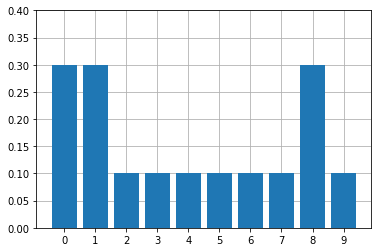

In [5]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale

belief = np.array([0.1] * 10)
reading = 1 # 1 is 'door'
update_belief(hallway, belief, z=reading, correct_scale=3.)
print('belief:', belief)
print('sum =', sum(belief))
plt.figure()
barPlot(belief, y_lim=0.4)

Das Histogramm oben stellt die Aufenthaltswahrscheinlichkeit für die zehn Türen nach einem initialen Messwert "Türe offen" dar. Aufgrund der Messunsicherheit des Sensors sind die Balken der Türpositionen 2-7 und 9 nicht mehr Null sondern 1/3 so groß wie die Balken der Türpositionen 0, 1 und 8.  
Damit das Histogram tatsächlich eine Wahrscheinlichkeitsdichte wiedergibt, muss es aber noch normiert werden: Die Summe aller Wahrscheinlichkeiten muss Eins ergeben. Diese Normierung kann einfach mit einer NumPy-Funktion durchgeführt werden.

In [6]:
belief / sum(belief)

array([0.1875, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.1875, 0.0625])

Die Funktion ``update_belief`` wird nun durch eine Normierung erweitert und in ``scaled_update`` umbenannt. Letztere Funktion erhalt als Übergabewert nicht mehr ``correct_scale`` sondern die Wahrscheinlichkeit für eine korrekte Messung, in diesen Fall der Wert 75 % statt wie vorher den Faktor 3,0.  
Damit die Ausführungsgeschwindigkeit für größere Datensätze und viele Iterationen akzeptabel bleibt, muss weiter die For-Schleife vermieden werden. Denn diese Schleife wird Schritt für Schritt im Python-Interpreter ausgeführt. Besser ist es, eine NumPy-Funktion dafür zu verwenden, denn darüber werden optimierte Laufzeitbibliotheken aufgerufen, die in C oder Fortran erstellt wurden.  

Folgende Codezeile der Funktion ``scaled_update``
```Python
belief[hallway==z] *= scale
```
ist nicht ohne größeres Pythonwissen auf Anhieb zu verstehen, daher eine kurze Erklärung:  
``hallway==z`` erzeugt ein boolsches Array mit "True" an den Indizes, bei denen das Array ``hallway`` den Wert z besitzt und "False" an den übrigen. ``belief[hallway==z]`` wählt die Arrayelemente mit diesen Indizes von ``belief`` aus. Die gesamte oben dargestellte Codezeile multipliziert dann diese Elemente mit dem Faktor ``scale``, die übrigen Elemente bleiben unberührt.

sum = 1.0
probability of door = 0.1875
probability of wall = 0.06249999999999999


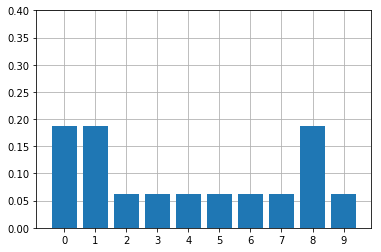

In [7]:
def scaled_update(hallway, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob) # same as correct_scale in code above
    belief[hallway==z] *= scale # replaces for loop in code of update_belief()
    belief = belief / sum(belief) # normalize to sum 1
    return belief

belief = np.array([0.1] * 10) # robot can be anywhere
updated_belief = scaled_update(hallway, belief, z=1, z_prob=.75) # Measurement "door open"

print('sum =', sum(updated_belief))
print('probability of door =', updated_belief[0])
print('probability of wall =', updated_belief[2])
plt.figure()
barPlot(updated_belief, y_lim=0.4)

Das Histogramm oben stellt nun eine plausible Wahrscheinlichkeitsverteilung dar: Die Aufenthaltswahrscheinlichkeiten jeweils für alle offenen Türen und alle geschlossene Türen sind gleich groß. Da eine Messung eine offene Tür mit einer Messunsicherheit von 25 % gemeldet hat, steht das Fahrzeug mit einer dreifach höheren Wahrscheinlichkeit vor einer offenen Tür als vor einer geschlossenen.  Die Summe aller Wahrscheinlichkeiten ergibt 1 - das Fahrzeug muss also irgenwo im Flur vor einer Tür stehen.

Diese oben dargestellte Annahme nennt man "Posterior", genauer gesagt "A-posteriori-Wahrscheinlichkeit". Vorher ging man noch davon aus, dass das Fahrzeug mit gleicher Wahrscheinlichkeit vor jeder Türe steht. Diese Annahme nennt man "Prior", genauer gesagt "A-Priori-Wahrscheinlichkeit".
**"Posterior" ist die Wahrscheinlichkeitsverteilung *nach* Berücksichtigung einer neuen Messung. Im Gegensatz dazu nennt man die Wahrscheinlichkeitsverteilung *vor* der Messung "Prior"** 
Anders ausgedrückt: "Prior" war die Enschätzung, dass dsa Fahrzeug mit einer Wahrscheinlichkeit von 10 % an jeder der zehn Türen stehen kann. Durch die rauschbehaftete Messung wird ein "posterior" erzeugt, bei dem berücksichtigt ist, dass es einen Sensorwert "offene Tür" gab, der aber nur zu 75 % wahr ist.

Später wird durch den Messwert die Vorhersage korrigiert. In diesem Sinne ist Posterior die Wahrscheinlichkeitsverteilung nach der Korrektur der Vorhersage mit einem Messwert.  

### Zurück zum g-h-Filter...
Genau wie beim g-h-Filter geht es im aktuellen Beispiel auch im eine Iteration:  
* Aus dem *Prior* wird in jedem Iterationsschritt unter Einbeziehung von Messdaten ein *Posterior*.  
* Beim g-h-Filter wurde aus einer *Vorhersage* unter Einbeziehung von Messdaten ein *Korrekturwert* generiert.  

**Dem Begriff *Prior* entspricht also der Begriff *Vorhersage*, dem Begriff *Posterior* der Begriff *Korrekturwert*.**

### Zusammenhang zwischen Prior, Likelihood und Posterior
Der im Quellcode berechnete Wert `belief[hall==z] *= scale` ist die unnormierte Wahrscheinlichkeitsverteilung. Diese nennt man auf Englisch "Likelihood". Allgemein kann also folgende mathematische Beziehung zwischen Prior, Likelihood und Posterior aufgestellt werden:  

$$\mathtt{Posterior} = \frac{\mathtt{Likelihood} \times \mathtt{Prior}}{\mathtt{Normierung}}$$ 

Prior ist also die normierte Wahrscheinlichkeitsverteilung vor der Messung, z.B. als Ergebnis einer Vorhersage. In Likelihood" steckt der Messwert und das Wissen über das System (hier über die Türen im Flur). Aus Likelihood und Prior wird die normierte Wahrscheinlichkeitsverteilung nach der Messung, der Korrekturwert oder Posterior berechnet.  
Der Code der Funktion ``scaled_update()`` lässt sich mit dieser Begrifflichkeit nochmals etwas vereinfachen:

In [8]:
def scaled_update(hallway, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hallway))
    likelihood[hallway==z] *= scale
    posterior = (likelihood * belief)/sum(likelihood * belief)
    return (posterior)

Die neue Korrektur-Funktion ``scaled_update()`` ist aber immer noch nicht generell anwendbar, da sie über die Variable ``hallway`` Informationen benötigt zum Flur selbst, und wie die Messwerte dem Muster der geöffneten Türen zugeordnet werden.  
Eine allgemeine Korrektur-Funktion sollte nur die Likelihood und den Prior als Variablen übergeben bekommen und daraus den Posterior berechnen:

> "Likelihood" macht aus einem "Prior" zusammen mit einer anschließenden Normierung einen "Posterior". In "Likelyhood" steckt sowohl das Messergebnis als auch dessen Interpretation, wie wahrscheinlich damit jeder der zehn Zustände ist. Die unterschiedlichen Zustände entsprechen jeweils den Elementen der Arrays "Prior", "Likelihood" bzw. "Posterior".

Eine wirklich generelle Korrektur-Funktion sollte daher so aussehen:

```python
def update(likelihood, prior):
    return normalize(likelihood * prior)
```

Je nach Anwendung wird die Likelihood unterschiedlich berechnet. Im Gedankenexperiment hier gibt der Sensor für die Türmessung etweder eine 1 (Türe offen) oder eine 0 (Türe geschlossen) zurück. An den bekannten Positionen der offenen Türen wird dann im Array das entsprechende Element (je nach Messergebnis) mit dem von der Messunsicherheit abgeleiteten Wert ``scale`` multipilziert, die übrigen Elemente bleiben unverändert. Damit wird ausgehend von der Gleichverteilung (Prior) die Likelihood konkret in diesem Fall berechnet.  

Eine anderer Sensortyp liefert beispielsweise den Winkel der Türöffnung zurück. Dann würde die Likelihood anders berechnet.  

Nachfolgend die (für das Gedankenexperiment spezifische) Funktion zur Berechnung der Likelihood sowie die schlussendliche Korrektur-Funktion.

In [9]:
def lh_hallway(hallway, z, z_prob):
    """Compute likelihood that a binary door measurement matches positions in the hallway."""    
    try: # This will catch the case if there is no measurement error
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError: # Give error report
        scale = 1e8
    likelihood = np.ones(len(hallway))
    # only state of likelihood equal to z will be scaled
    likelihood[hallway==z] *= scale # [hallway==z] selects index of position z
    return likelihood

def update(likelihood, prior):
    """Compute posterior based on likelihood and prior."""
    posterior = (likelihood * prior)/sum(likelihood * prior)
    return (posterior)
    
    
belief = np.array([0.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
update(likelihood, belief)  

array([0.1875, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.1875, 0.0625])

## Vorhersagen durch Einbeziehung unverrauschter Bewegungsmesswerte

In dem exemplarischen Beispiel oben ohne Rauschen in den Messwerten konnte die Position des Fahrzeugs schon nach einer Iteration ohne Restunsicherheit bestimmt werden. Unter nicht solch optimalen Startbedingungen hätte es vielleicht etwas länger gedauert - aber auch hier würde die Wahrscheinlichkeitsverteilung der Fahrzeugposition schnell konvergieren. 
Würde man so eine eindeutige Positionsbestimmung auch mit verrauschten Sensordaten erreichen?  
Die Antwort hierzu ist ein klares Nein.  
Man kann sich nie zu 100 % sicher sein, dass eine Zustandsannahme wirklich der Realiät entspricht. Technisch ist dies auch gar nicht gefordert. Welcher Sicherheitsingenieur gibt uns eine Garantie, dass das Kernkraftwerk in der Nachbarschaft kein Restrisiko eines GAUs besitzt? Ein Politiker mag das sicher tun, aber kein seriöser Ingenieur.  

Ein autonom fahrendes Auto wird übrigens auch losfahren, wenn es die Fahrbahnmarkierung nur mit einer Sicherheit von 99,999 % erkannt hat. Je nach Anwendung gibt man sich in der Technik mit einem einem entsprechenden Sicherheitsniveau zufrieden. Bei einem Staubsaugerroboter wird dieses Niveau sicherlich etwas niedriger liegen als bei einem autonom fahrenden Auto.  

Bisher gingen in die Berechnungen nur die verrauschten Türmessdaten ein. Nun sollen auch die Bewegungsmesswerte mit hinzugezogen werden. Zunächst wird angenommen, dass die Bewegungsmesswerte anders als die Türmesswerte unverrauscht sind.  
Mit den Bewegungsmesswerten soll eine Vorhersage über die Wahrscheinlichkeitsverteilung der Fahrzeugposition berechnet werden.  
Wie muss sich die Positionsannahme ``belief`` ändern, um eine Bewegung mit einzubeziehen?  

Die Antwort hierauf lässt sich intuitiv finden: Bewegt sich das Roboterfahrzeug nach rechts, dann müssen alle Arrayelemente der Positionsannahme auch um eine Position nach rechts, also zu einem höhern Index, verschoben werden. Bei einer Bewegung nach Links, müssen die Elemente jeweils zum nächst kleineren Index hin rücken.  
Wenn zuvor das Fahrzeug mit hoher Wahrscheinlichkeit an Position 5 vermutet wurde, so wird es nach einer Rechtsbewegung an Position 6 vermutet.

Es gibt dabei nur ein Problem: Was passiert mit der Position 0 bei einer Bewegung nach Links bzw. für Position 9 bei einer Bewegung nach Rechts? Bisher wurde angenommen, der Flur sein perfekt gerade. Die Mathematik wird aber einfacher, wenn der Flur kreisförmig ist und rechts neben der Türe 9 wieder die Türe 0 liegt.  
Architektonisch ist ein solcher Flur sicher eine Herausforderung, mathematisch aber nicht.  

Der folgende Code beinhaltet sowohl das Versetzen der Wahrscheinlichkeitsverteilung als Reaktion auf eine Bewegung als auch die mathematische Kreisförmigkeit des Flurs.

<Figure size 432x288 with 0 Axes>

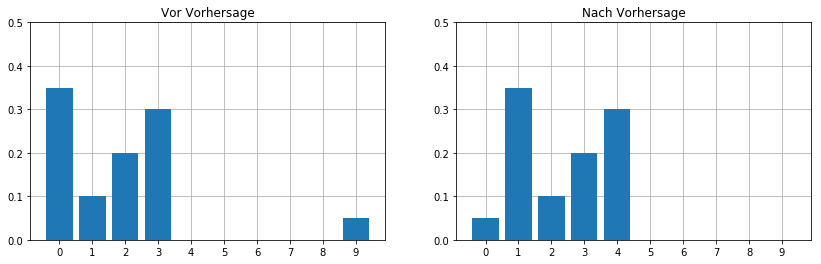

In [10]:
def perfect_predict(belief, move): # prediction without error
    """ move the position by `move` spaces, where positive is 
    to the right, and negative is to the left
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n]
    return result
        
belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
belief_predict = perfect_predict(belief, 1)

def twoBarPlots(plot_one, title_one, plot_two, title_two, y_lim=1.1): # Function will bei used again later
    x = np.arange(len(plot_one))
    plt.figure(figsize=(14,4))

    plt.subplot(121) # First of two plots side by side
    plt.grid(zorder=0)
    plt.ylim(0,y_lim)
    plt.xticks(x)
    plt.title(title_one)
    plt.bar(x,plot_one,color='C0',zorder=3)

    plt.subplot(122) # Second of two plots side by side
    plt.grid(zorder=0)
    plt.ylim(0,y_lim)
    plt.xticks(x)
    plt.title(title_two)
    plt.bar(x,plot_two,color='C0',zorder=3)
    
plt.figure()
twoBarPlots(belief, 'Vor Vorhersage', belief_predict, 'Nach Vorhersage', y_lim=0.5)

Vergleicht man beide Plots oben, so ist gut sichtbar, wie sich die Wahrscheinlichkeitsverteilung um eine Position nach Rechts verschoben hat. Der kleine Balken von Position 9 ist dabei auf Position 0 gerückt. 

Der folgende Code führt diesen Vorhersageschritt zehn Mal immer erneut als Animation durch, als würde das Fahrzeug jedes Mal eine Position nach Rechts fahren. Da zwischen den Bewegungen keine neuen Türmesswerte hinzukommen, verschiebt sich die Wahrschlichkeitsverteilung nur jeweils um eine Position nach Rechts. Nach der 10. Iteration ist die Wahrschlichkeitsverteilung wieder so wie am Anfang.

<IPython.core.display.Javascript object>


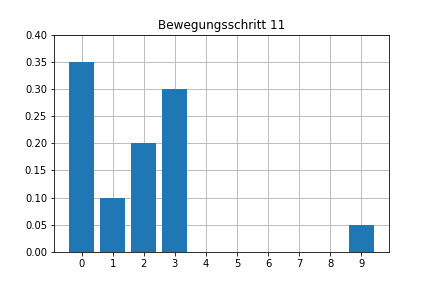

In [11]:
import time
# switch to interactive plot settings
%matplotlib notebook

belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
x = np.arange(len(belief))
fig = plt.figure()
for i in range(11):
    belief_predict = perfect_predict(belief, 1)
    plt.cla() # clear current axis (=previous plot)
    plt.bar(x,belief,color='C0',zorder=3)
    plt.grid(zorder=0)
    plt.ylim(0,0.4)
    plt.xticks(x)
    plt.title('Bewegungsschritt {}'.format(i+1))
    fig.canvas.draw() # redraw figure with current plot data
    time.sleep(0.5) # wait for 0.5 seconds
    belief = belief_predict # prediction is belief in next iteration
# reset to noninteractive plot settings    
%matplotlib inline

**Achtung:** *Die Animation funktioniert nur, wenn dieses Jupyter-Notebook auf einem Server (lokal auf dem Rechner oder im Internet mit dem Webservice "Binder") ausgeführt wird. Wird es z.B. über GitHub nur visualisert, dann wird nur das letzte Bild der Animation angezeigt.*

## Begrifflichkeiten

An diesem Punkt soll nochmals Klraheit über die Begrifflichkeiten rund um den g-h-, Bayes- oder Kalman-Filter geschaffen werden. Denn ein Verstehen des Kalman-Filters scheitert bei Lektüre der meisten Lehrbücher leider oft nur an den dort verwendeten Begriffen. Thema Herrschaftswissen also.

* **Man versucht das *System* zu modellieren, um darauf den Filter anzuwenden.**  
In Gedankenexperiment ist das System ein Roboterfahrzeug, welches entlang eines kreisförmigen Flurs fährt, von dem auf einer Seite im regelmäßigem Abstand Türen abgehen, von denen einige offen und einige geschlossen sind.  

* **Der *Zustand* ist die aktuelle Konfiguration oder Konstellation des Systems**  
Im Gedankenexperiment gibt es so viele Zustände wie Türpositionen, an der das Fahrzeug stehen kann. Also zehn Zustände, die den Elementen des Arrays ``belief``entsprechen.  

* **Den (wahren) Zustand kenn man meistens nicht, weshalb ein Filter angewendet wird, der dafür einen *Schätzwert* liefert.**  
Im Gedankenexperiment ist der Schätzwert die Wahrscheinlichkeitsverteilung der Fahrzeugposition. Viele Lehrbücher bringen leider die Begriffe *Zustand* und *Schätzwert* durcheinander.  

* **Ein *Messwert* ist ein aktueller Wert eines Zustandes, welcher mit Messunsicherheit behaftet ist.**  
Im Gedankenexperiment wird der Zustand "Fahrzeugposition" indirekt über den Türsensor gemessen. Der Messwert ist hier "Türe offen" oder "Türe geschlossen".  

* **Der Filter besteht aus den beiden Iterationsschritten *Vorhersage* sowie *Messung/Korrektur*. Eine Iteration wird *Time evolution* oder auch *Systempropagation* genannt.**  
Im Gedankenexperiment ist die Systempropagation die Änderung der Fahrzeugposition mit der Zeit.  

* **Das System wird mittels eines *Prozessmodells* modelliert.**
Im Gedankenexperiment ist dies das Fahrzeug, welches dem Flur folgt und sich schrittweise vorwärts oder rückwärts von Tür zu Tür bewegt.  

* **Die Unsicherheit im *Prozessmodell* wird *System Error* oder *Process Error* genannt.**  
Im Gedankenexperiment gibt es bisher noch keine Unsicherheit im Prozessmodell. Daher ist es auch ein Gedankenexperiment.  

* **Bei einem Iterationsschritt ist die Vorhersage der neue *Prior*, die Zustandsschätzung durch die Korrektur mit Hilfe eines Messwerts nennt man *Posterior*.**  
Im Gedankenexperiment wird die Vorhersage mit Hilfe des Bewegungsmesswerts erstellt und wirkt sich als Verschiebung der Posterior-Wahrscheinlichkeitsverteilung aus.  

## Vorhersagen mit verrauschten Bewegungsmesswerten

Die Funktion `perfect_predict()` nimmt perfekte Bewegungen des Fahrzeugs an: Wurde eine Bewegung nach Rechts gemeldet so hat diese auch tatsächlich stattgefunden, und das Fahrzeug hat sich wirklich in diese Richtung um nur eine Türposition bewegt.  
Die Bewegungsinformation stammt aber auch von einem Sensor mit Messunsicherheit: Es gibt z.B. eine gewisse Wahrscheinlichkeit, dass das Fahrzeug tatsächlich um zwei Türpositionen vorgerückt ist, obwohl der Sensor nur einen Schritt gemeldet hat.  

Um diese Unsicherheit zu modellieren, muss das Gedankenexperiment nochmals ausgeweitet werden:  
Das Fahrzeug soll nun nicht nur seine Fahrtrichtung ändern können, sondern auch unterschiedlich schnell fahren. Je nach Geschwindigkeit kann es jetzt dabei auch mehrere Türpositionen vorrücken. Vielleicht handelt es sich bei dem Roboter um einen Putzroboter, der je nach Verschmutzung unterschiedlich schnell fährt.  

Angenommen der Bewegungssensor liefert mit 80 % Wahrscheinlichkeit einen korrekten Bewegungswert. Mit jeweils 10 % Wahrscheinlichkeit misst er eine Türposition pro Sekunde zu viel bzw. zu wenig.  
Wenn der Sensor also eine Bewegung von beispielsweise vier Türpositionen (pro Sekunde) meldet, dann stimmt dies mit einer Wahrscheinlichkeit von 80 %. In 10 % der Falle fand tatsächlich aber eine Bewegung um fünf Türpositionen und in weiteren 10 % eine Bewegung um drei Türpositionen statt.

### Exemplarisches Beispiel: Verrauschte Bewegungsmesswerte und unverrauschte initiale Positionsannahme
Bisher war der Input der Vorhersage eine -1, 0 oder +1 als Messwert des Bewegungssensors. Jetzt gibt der Bewegungssensor eine ganze Zahl aus, z.B. -3, 2, 0 oder +3. Dieser Messwert wird nun mit einem Array "verrauscht", in dem die o.g. Wahrscheinlichkeiten 0,1, 0,8 und 0,1 stehen. Damit ergibt sich ein Array mit Wahrscheinlichkeitsdichten als Input der Vorhersage, mit dem ein Vorhersagewert berechnet wird.  
Der Funktion ``predict_move()`` werden die aktuelle Positionsannahme, der Messwert des Bewegungssensors sowie die drei Wahrscheinlichkeiten übergeben. Sie berechnet daraus eine neue Positionsvorhersage (Prior) unter Berücksichtigung des verrauschten Bewegungsmesswerts.

<Figure size 432x288 with 0 Axes>

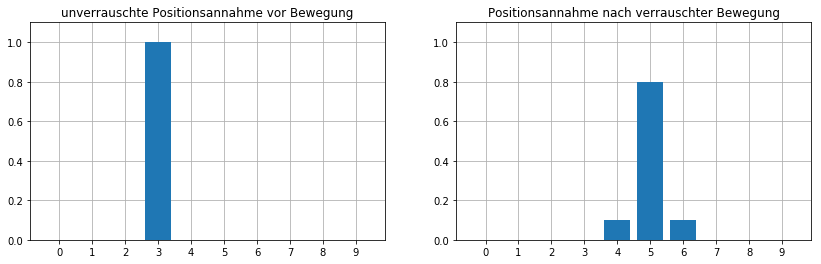

In [12]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    return prior

belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior = predict_move(belief, 2, .1, .8, .1) # moved 2 door positions with +/-1 error (10%)

plt.figure()
twoBarPlots(belief, 'unverrauschte Positionsannahme vor Bewegung', prior, 'Positionsannahme nach verrauschter Bewegung')

### Exemplarisches Beispiel: Verrauschte Bewegungsmesswerte und verrauschte initiale Positionsannahme
In den beiden Plots oben war die initiale Positionsannahme unverrauscht. Die Funktion ``predict_move()`` lässt sich aber genau so auf eine Position in Form eine Wahrscheinlichkeitsverteilung anwenden. Die Varialbe ``belief`` wird im code entsprechend geändert:

array([0.  , 0.  , 0.  , 0.04, 0.38, 0.52, 0.06, 0.  , 0.  , 0.  ])

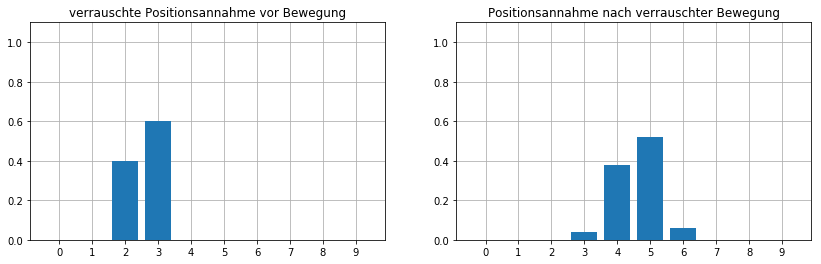

In [13]:
belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0]
prior = predict_move(belief, 2, .1, .8, .1)
twoBarPlots(belief, 'verrauschte Positionsannahme vor Bewegung', prior, 'Positionsannahme nach verrauschter Bewegung')
prior

Der Schritt vom linken zum rechten Plot ist hier schon etwas schwerer nachzuvollziehen als bei dem Beispiel mit unverrauschten Positionsdaten. Wie kommen die Elemente des arrays ``prior`` zustande?  
Die 0,04 am Index 3 stammt von der 0,4 des arrays ``belief``, die mit einer Wahrscheinlichkeit von 10 % nach rechts rückt. Denn die gemessene Bewegung war 2 Positionen nach Rechts. D.h. eine Position weniger nach Rechts tritt mit einer Wahrscheinlichkeit von 10 % ein. Somit wird die 0,4 mit 0,1 multipliziert und dann eine Position nach rechts verschoben.  
Die 0,38 am Index 4 des arrays ``prior`` berechnet sich zu 0,8 mal dem Element 0,4 von ``belief``, denn dieses wurde ja mit einer Wahrscheinlichkeit von 80 % um 2 Positionen nach Rechts verschoben. Hinzu kommt aber noch 0,1 mal das Element 0,6 von ``belief``, welches mit einer Wahrscheinlichkeit von 10 % um 1 Position nach Rechts verschoben wird. Dies ergibt $0,8 \cdot 0,4 + 0,1 \cdot 0,6 = 0,38$.  

>**Für das Verständnis der nachfolgenden Abschnitte ist es wichtig, diese Verkettung von Wahrscheinlichkeiten - der Wahrscheinlichkeitsdichte der Position und der Bewegung - verstanden zu haben.**
Die Berechnung ähnelt start einer Multiplikation eines eindimensionalen Arrays (oder Vektor) mit einem zweidimensionalen Array (oder Matrix). Die Operation die damit ausgeführt wird, ist eine *Faltung*: Die Wahrscheinlichkeitsverteilung der Position wird durch eine Faltung mit dem Bewegungsarray "verschmiert".  

"Verschmieren" ist zwar kein mathematischer Ausdruck. Es trifft diesen Prozess einer Vorhersage basierend auf verrauschten Bewegungsmesswerten aber sehr gut: Im rechten Plot oben ist das Fahrzeug schlechter lokalisiert als im linken Plot: Die Wahrscheinlichkeitsverteilung wird niedriger und zugleich breiter.  
Das ist nich verwunderlich, sondern war so zu erwarten: **Eine auf verrauschte Sensormessdaten basierende Vorhersage reduziert die Genauigkeit - also den Informationsgehalt - der Positionsannahme**  

Die folgende Animation soll dies verdeutlichen: Hier wird der Vorhersageschritt mit den selben Parametern 30 mal hintereinander durchgeführt. Bei jeden Schleifendurchlauf nimmt die Unsicherheit der Positionsannahme im Array ``belief`` zu. Am Ende ergibt sich fast eine Gleichverteilung auf alle Türpositionen: Die Information über die Fahrzeugposition tendiert bei sehr vielen Iterationen also gegen Null.  
Gäbe es zwischen jeder Voraussage noch eine Türmessung, dann würde der Informationsgehalt bei jeder Iteration nach der Korrektur wieder zunehmen. Später wird genau dies betrachtet, was der Realität entspricht und Sinn und Zweck des Filters ist.

<IPython.core.display.Javascript object>


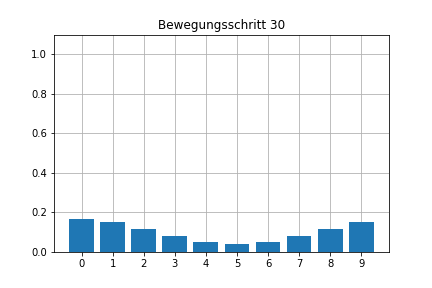

Final Belief: [0.1645062  0.1510072  0.11732805 0.07893735 0.0504189  0.04011079
 0.0504189  0.07893735 0.11732805 0.1510072 ]


In [14]:
# switch to interactive plot settings
%matplotlib notebook

belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
x = np.arange(len(belief))
fig = plt.figure()
for i in range(30):
    belief = predict_move(belief, 1, .1, .8, .1)
    plt.cla() # clear current axis (=previous plot)
    plt.bar(x,belief,color='C0',zorder=3)
    plt.grid(zorder=0)
    plt.ylim(0,1.1)
    plt.xticks(x)
    plt.title('Bewegungsschritt {}'.format(i+1))
    fig.canvas.draw() # redraw figure with current plot data
    time.sleep(0.1) # wait for 0.5 seconds
print('Final Belief:', belief)
# reset to noninteractive plot settings    
%matplotlib inline

## Allgemeine Rechnung mit verrauschen Positionsannahmen und verrauschen Bewegungmesswerten

In dem exemplarischen Beispiel oben war der maximale Fehler der Bewegungsmessung +/- eine Position. Dies soll nun allgemeiner gefasst werden. Nachfolgend wird aus der Fuktion ``predict_move()`` die Funktion ``predict_move_convolution()`` entwickelt, die auch größere Messfehler wie zwei oder drei Türpositionen berücksichtigt. Es ist aber nach wie vor der Fall, dass *nur Bewegungsschritte jedoch keine neuen Türmessschritte betrachtet werden*.    
Wie schon erwähnt, ist die mathematische Operation der *Faltung* hierfür optimal geeignet. Bei einer Faltung wird eine Funktion durch eine anderen Funktion verändert. Im hier vorliegenden Fall wird die Wahrscheinlichkeitsverteilung der Fahrzeugposition durch die Funktion der Fehlerverteilung des Bewegungssensors modifiziert.  
**Die Implementierung der Funktion ``predict_move()`` oben ist im Ergebnis tatsächlich schon eine Faltung**  

Sie ist bloß nur formal nicht als solche leicht zu erkennen. Eine Faltung ist definiert als

$$ (f \ast g) (t) = \int_0^t \!f(\tau) \, g(t-\tau) \, \mathrm{d}\tau$$

wobei die Schreibweise $f\ast g$ bedeutet f wird mit g gefaltet.  

**Achtung: Falten bedeutet nicht Multipizieren:**
$ f\ast g \neq f \cdot g$. Bei der Faltung verschwindet die Variable $\tau$ durch die Integration. Die Variable $t$ ist so etwas wie ein Aufpunkt für das Falten. Mann kann sich das Falten gut so vorstellen, dass die Funktion $g$ wíe eine Schablone über die Funktion $f$ gelegt wird, und dabei das durch die  Schablone Sichbare aufintegriert wird. Die Variable $t$ bestimmt dabei den Ort von $f$, an dem die Schablone aufgelegt wird.  
In der Bildverarbeitung bedeutet Falten z.B. Weichzeichnen: Hier kann man sich das Falten so vorstellen, dass eine kleine Streuscheibe über das Bild gelegt wird.  

Die Definition der Faltung oben verwendet Integrale und ist daher für kontinuierliche Funktionen gedacht. In der digitalen Datenverarbeitung dreht sich Alles um diskrete Werte, die z.B. als Arrays vorliegen. Daher wird hier das Integral durch eine Summe ersetzt und die runden Klammern duch eckige Array-Klammern:

$$ (f \ast g) [t] = \sum\limits_{\tau=0}^t \!f[\tau] \, g[t-\tau]$$

Die schon verwendete Funktion `predict_move()` folgt genau dieser Gleichung - sie berechnet die Summe aus einer Folge von Multiplikationen.  

**Nochmals zum sicheren Verständnis des Grundprinzips:** Bei der Faltung wird ein Array (*Kernel* genannt) gegen ein zweites Array verschoben. Man sagt *das letztere Array wird mit dem Kernel gefaltet.*  
Der Index $t$ gibt dabei an, um wieviel die beiden Arrays gegeneinander verschoben sind. Zur Faltung werden die beiden Elemente der Arrays, die sich überdecken miteinander multipliziert und dann aufaddiert.  

Genau das wird in der neuen Funktion ``predict_move_convolution()`` durchgeführt. Die Variable ``belief`` wird nun in ``pdf`` umgetauft. ``pdf`` steht für Probability Density Fuction (Wahrscheinlichkeitsdichtefunktion). Dies macht Sinn, denn eine Annahme wird in Form einer Wahrscheinlichkeitsdichtefunktion quantifiziert.

In [15]:
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1) / 2)

    prior = np.zeros(N)
    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

Der Code oben ist aufgrund der For-Schleife recht langsam. Viel schneller ist die Faltungs-Funktion `convolve()` aus dem SciPy-Package, die schon in der NumPy-Version bei dem Beispielen zum g-h-Filter für die gleitende Mittelwertbildung verwendet wurde (leider gibt es in der NumPy-Version nicht den Modus "wrap" für die hier verwendeten "kreisförmigen" Arrays). Die ``pdf`` muss jedoch vorher noch mit der Funktion ``np.roll()`` um den ``offset`` verschoben werden.  

Damit kann der Bewegungs-/Vorhersageschritt nun mit einer Codezeile implementiert werden:

```python
convolve(np.roll(pdf, offset), kernel, mode='wrap')
```

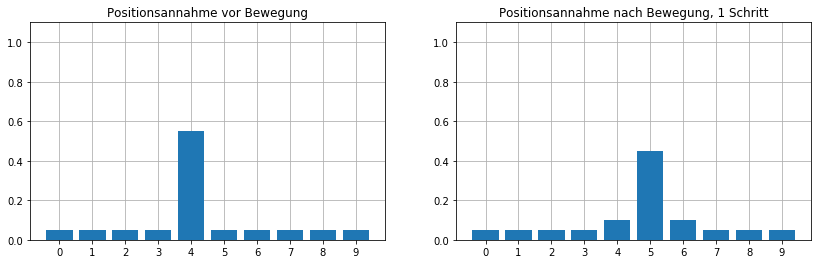

In [16]:
from scipy.ndimage.filters import convolve

def predict(pdf, offset, kernel):
    prior = convolve(np.roll(pdf, offset), kernel, mode='wrap')
    return prior

belief = [.05, .05, .05, .05, .55, .05, .05, .05, .05, .05]
prior = predict(belief, offset=1, kernel=[.1, .8, .1])
twoBarPlots(belief, 'Positionsannahme vor Bewegung', prior, 'Positionsannahme nach Bewegung, 1 Schritt')

Von den Elementen des Arrays Prior sollten sich nur die mit Index 3 bis 5 ändern: Die Werte bei Index 4 und 6 berechnen sich zu  

$$(0.1 \times 0.05)+ (0.8 \times 0.05) + (0.1 \times 0.55) = 0.1$$  

Der Wert des Index 5 berechnet sich zu $$(0.1 \times 0.05) + (0.8 \times 0.55)+ (0.1 \times 0.05) = 0.45$$  

Als nächstes wird getestet, ob eine Bewegung um drei Positionen mit dieser neuen Funktion auch funktioniert:

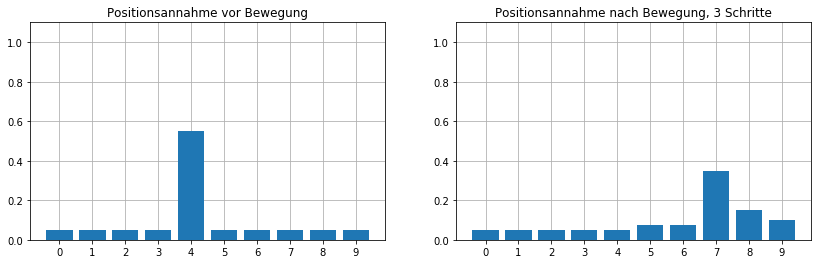

In [17]:
prior = predict(belief, offset=3, kernel=[.05, .05, .6, .2, .1])
twoBarPlots(belief, 'Positionsannahme vor Bewegung', prior, 'Positionsannahme nach Bewegung, 3 Schritte')

Auch hier sieht das Ergebnis wieder plausibel aus, zumal der Bewegungssensor nun etwas asymmetrisch rauscht: Messabweichungen ins Positive sind wahrscheinlicher als ins Negative.  

**Nochmals zum Test des Grundverständnisses:**  
Sowohl die Wahrscheinlichkeitsdichte der Position als auch der Messwert der Bewegung liegen jeweils als Array vor. Die Vorhersage erzeugt die Wahrscheinlichkeitsdichte für den nächsten Zeitpunkt (Prior genannt) mittels einer Faltung des Bewegungsarrays mit Wahrscheinlichkeitsdichte zum aktuellen Zeipunkt.   

Allgemein drückt man dieses mathematische Vorgehen mit folgender Formel aus:

$$ \bar{ \mathbf x}_{k+1} = \mathbf x_k \ast f_{\mathbf x}(\bullet)$$

$f_x(\bullet)$ steht für die "Propagationsfunktion" des Zustands. Einfacher ausgedrückt: Sie legt fest wie viel die Elemente des Vektors $x_k$ sich während eines Samplingintervalls ändern. 
**Die aktuelle Wahrscheinlichkeitsdichte der Position wird mit einer statistischen Annahme über die Bewegung *gefaltet*.**
Der Index $k$ bezeichnet nun die aufeinander folgenden Iterationen bzw. Zeitpunkte. $\mathbf x$ ist fettgedruct, denn es steht für einen Array. Die Elemente dieses Arrays sind die verschiedenen Wahrscheinlichkeiten für die unterschiedlichen Zustände (hier Positionen). 

## Iterationen aus Türmessungen *und* Bewegungsvorhersagen

Bis hierhin gab es nur eine initiale Wahrscheinlichkeitsdichteverteilung der Position. Dies kann z.B. das Ergebniss einer Türmessung sein, wie weit oben in diesem Abschnitt auch dargestellt wurde. Die Verteilung wurde dann durch einen oder viele aufeinanderfolgende Vorhersagen aufgrund einer Bewegungsmessung "propagiert" oder besser gesagt "verschmiert". Natürlich entspricht das nicht der Realität eines Kalman-Filters, denn bei jeder Vorhersage wird die Positionsinformation diffuser.  

**Nun wird endlich der realistische Fall betrachtet, dass sowohl eine Türmessung als auch eine Bewegungsvorhersage pro Iteration stattfindet. Jede Vorhersage wird von einer Korrektur gefolgt, bei dem eine neue Türmessung mit einbezogen wird.** Dieser Korrektur-Schritt *erhöht* das Wissen über die Fahrzeugposition. Mit dieser konkreteren Information wird eine Vorhersage berechnet, die dieses Wissen wieder etwas diffuser macht. Das Vorhersageergebniss wir in der nächten Iteration jedoch wieder durch eine Korrektur mit einer Türmessung konkretisiert usw.  
Durch diesen Prozess steigt das Wissen über die Position von Iteration zu Iteration, d.h. das Fahrzeug wird Schritt für Schritt besser lokalisiert.  

Intuitiv lässt sich dies an folgendem Bewegungsbeispiel gut nachvollziehen: Das Fahrzeug steht vor Türposition 1 und der Bewegungssensor meldet keine Bewegung: Dann wird die Wahrscheinlichkeitsdichte der Position von Iteration zu Iteration immer mehr auf Position 1 verdichtet. Im Positionsarray konvergiert der Wert des Elements 1 gegen 1.  
Fährt das Fahrzeug auf einemal Schritt für Schritt zur Türposition 9, dann wird der Bewegungssensor 8 Mal einen entsprechenden Messwert ausgeben. Der Filter verschiebt die Wahrscheinlichkeitsverteilung in den jeweiligen Vorhersagen somit jeweils um eine Position nach rechts, verschmiert aber gleichzeitig den zuvor gewachsenen Peak im Positionsarray. Sobald das Fahrzeug an Position 9 steht, bildet sich ein neuer Peak am Index 9 des Positionsarrays aus.

*Was würde passieren, wenn es gar keinen Bewegungssensor am Fahrzeug gäbe?*  
Auch dann könnte der Filter aufgrund der sich ändernden Türmessdaten erkennen, dass sich das Fahrzeug nach Rechts bewegt, wenn dies im dessen physikalischen Modell so vorgesehen ist. Im Abschnitt zum g-h-Filter gab es im Modell ja auch eine Geschwindigkeit (die Abstandsänderung), ohne dass diese explizit von einem extra Sensor hierfür gemessen wurde.

**Die Iteration aus *Vorhersage* und *Korrektur* kann jetzt sofort implementiert werden, da die beiden Funktionen ``predict()`` und ``update()`` dazu schon erstellt wurden.**
Nachfolgend wird eine solche Iteration für das Fahrzeug durchgeführt. Anders als bisher wird als Startpunkt nicht die bekannte Position 0 sondern eine völlig unbekannte Position gewählt. Die Positionsannahme Prior hat zum Start also in jedem Element den Wert 1/10 - das Fahrzeug kann überall sein. Dieser Startwert stellt in der Filteriteration den ersten Vorhersagewert, also den ersten Prior da.  
**Im Korrektur-Schritt wird anschließend mit Hilfe des ersten Türmesswerts aus dem Vorhersagewert (Prior) ein Korrekturwert (Posterior) berechnet.**

Der nachfolgende Plot zeigt Histogramme dieser beiden Wahrscheinlichkeitsverteilungen. 

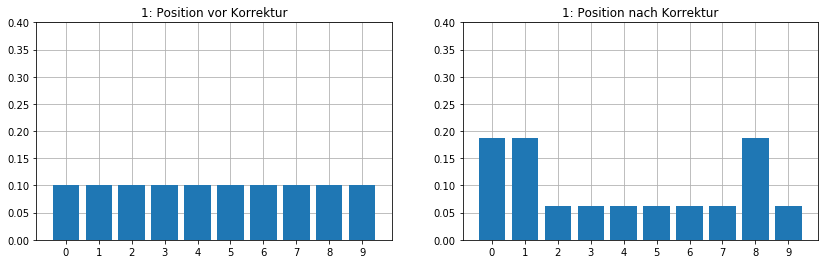

In [18]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
initial_prior = np.array([.1] * 10) # no position information at all
prior = initial_prior
likelihood = lh_hallway(hallway, z=1, z_prob=.75) # 1 stands for detection of open door
posterior = update(likelihood, prior)
twoBarPlots(prior, '1: Position vor Korrektur', posterior, '1: Position nach Korrektur', y_lim=0.4)

Der linke Plot oben zeigt die Ausgangslage mit Null Wissen zur Fahrzeugposition. Der rechte Plot zeigt die Wahrscheinlichkeitsverteilung nach dem der Türsensor die Türe als offen detektiert hat. Dadurch sind an den Indizes 0, 1 und 8 die Aufenthaltswahrscheinlichkeiten angewachsen. **Der Übergang vom linken zum rechten Plot ist der "Korrekturschritt"**    

Nach diesem Korrektur-Schritt folgt ein Vorhersageschritt: Mit der Information des Bewegungssensors (hier Bewegung nach rechts) wird aus dem Posterior ein neuer Prior erzeugt.

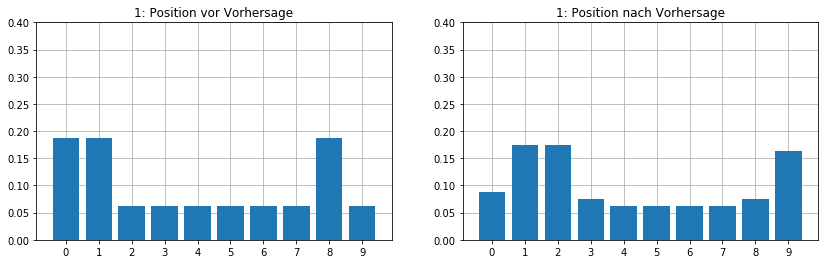

In [19]:
kernel = (.1, .8, .1)
new_prior = predict(posterior, 1, kernel) # prediction with movement one step to the right
twoBarPlots(posterior, '1: Position vor Vorhersage', new_prior, '1: Position nach Vorhersage', y_lim=0.4)

Die Wahrscheinlichektsverteilung wird durch die Faltung mit dem Kernel um eine Position nach rechts verschoben und etwas ausgeschmiert, wie im Vergleich der beiden Plots oben gut sichtbar ist.  
**Der Übergang vom linken zum rechten Plot ist der "Vorhersageschritt"**  

Nun beginnt die zweite Iteration mit dem nächten Korrekturschritt. Angenommen, der Türsensor detektiert eine offene Türe. Damit ergibt sich grafisch dargestellt folgender Übergang:

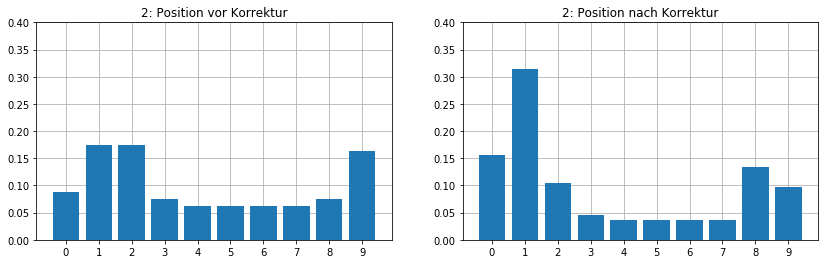

In [20]:
prior = new_prior
likelihood = lh_hallway(hallway, z=1, z_prob=.75) # open door detected
new_posterior = update(likelihood, prior)
twoBarPlots(prior, '2: Position vor Korrektur', new_posterior, '2: Position nach Korrektur', y_lim=0.4)

Infolge der Erkennung der offenen Tür wird der aktuelle Array Prior mit dem Array ``likelyhood`` multipliziert (darin steckt das Messergebnis z=1 sowie dessen Signifikanz ``z_prob``). Dadurch steigen die Wahrscheinlichkeiten an den Positionen 0, 1 und 8. 
Die Wahrscheinlichkeitsverteilung der Position wird deshalb konkreter, weil nun erneut eine offene Tür detektiert wurde nachdem das Fahrzeug eine Position nach Rechts gefahren ist. Dies passt zu der im "Modell" angenommenen Verteilung der offenen Türen.  

**Als Nächstes wird die dritte Iteration in einem Rutsch durchgeführt. Die beiden Plots zeigen also den Korrekturwert nach Iteration 2 und den Posterior nach Iteration 3.**

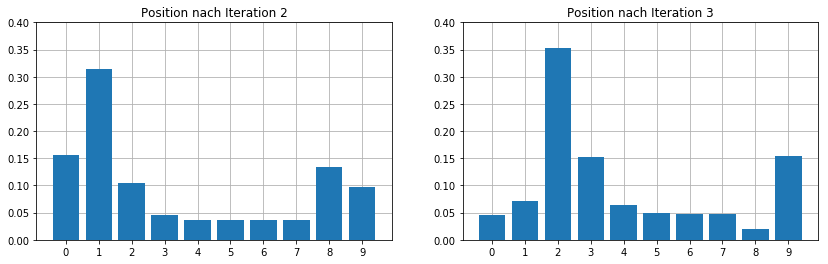

In [21]:
posterior = new_posterior
new_prior = predict(posterior, 1, kernel) # prediction with movement one step to the right
likelihood = lh_hallway(hallway, z=0, z_prob=.75) # closed door detected
prior = new_prior
new_posterior = update(likelihood, prior)
twoBarPlots(posterior, 'Position nach Iteration 2', new_posterior, 'Position nach Iteration 3', y_lim=0.4)

*Achtung: Die beiden Plots oben stehen nicht mehr nur für einen einzelnen Vorhersage- bzw. Korrekturschritt. Sie stellen nun jeweils die Positionsannahme (Posterior) nach einer kompletten Iteration aus Vorhersage und Korrektur dar.*
Der Sensor detektiert eine Bewegung nach rechts um einen Schritt. Obwohl die Vorhersage mit den verrauschten Bewegungsmessdaten immer etwas die Daten verschmiert, tritt im rechten Plot die Position 3 trotzdem deutlicher hervor als die Position 2 im Plot links.  

Der Filter scheint zu funktionieren. Also auf zu den nächsten beiden Iteration:

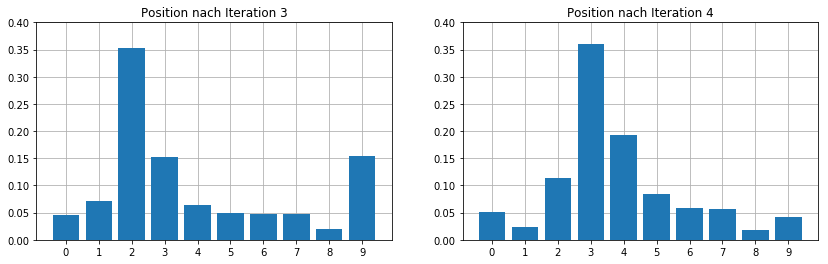

In [22]:
posterior = new_posterior
new_prior = predict(posterior, 1, kernel) # prediction with movement one step to the right
likelihood = lh_hallway(hallway, z=0, z_prob=.75) # closed door detected
prior = new_prior
new_posterior = update(likelihood, prior)
twoBarPlots(posterior, 'Position nach Iteration 3', new_posterior, 'Position nach Iteration 4', y_lim=0.4)

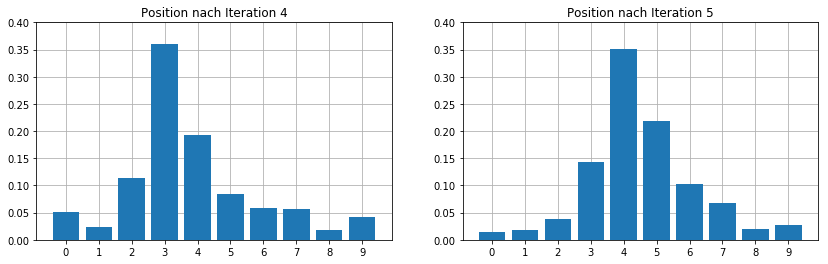

In [23]:
posterior = new_posterior
new_prior = predict(posterior, 1, kernel) # prediction with movement one step to the right
likelihood = lh_hallway(hallway, z=0, z_prob=.75) # closed door detected
prior = new_prior
new_posterior = update(likelihood, prior)
twoBarPlots(posterior, 'Position nach Iteration 4', new_posterior, 'Position nach Iteration 5', y_lim=0.4)

Weil es nur wenige offene Türen gibt, wird die Lokalisierung des Fahrzeugs nach Iteration 4 und 5 nicht deutlich konkreter. Denn es wurde ja jeweils eine geschlossene Tür gemessen, die 7 der 10 Positionen zugeordnet werden kann.  
Die Faltung mit dem Bewegungsarray (Vorhersageschritt) verschmiert immer die Verteilung etwas. Die Multiplikation mit der Likelyhood (Korrekturschritt) kann dies aber nicht immer gegenkompensieren.  

## Rückblick auf den g-h-Filter des ersten Notebooks
Für die Vorhersagen wird in den obigen Beispielen die Bewegungsinformation durch einen verrauschten Bewegungssensor verwendet. Im Notebook zum g-h-Filter kam jedoch die Bewegungsinformation (Abstandsänderung zur Wand) aus dem physikalischen Modell, dessen Parameter über den Messwertverlauf des Abstands aktualisiert wurden.  
Weiter unten wird eine dritte Möglichkeit verwendet, um den Vorhersageschritt mit den nötigen Informationen zu versorgen: Wenn das Roboterfahrzeug gesteuert wird, dann können die Steuerbefehle für die Bewegung als Input verwendet werden.  

Ein ganz wesentlicher Unterschied zwischen dem g-h-Filter im ersten Notebook und dem Bayes-Filter sind die *Statistik-Grundlagen*:  
Im ersten Notebook sind im Filteralgorithmus keine statistischen Berechnungen zu finden. Die Zustandsgröße Abstand zur Wand konnte innerhalb der Sensorauflösung beliebige Werte annehmen. Implizit wurde angenommen, dass der Schätzwert des Wandabstands um den (einen) wahren Wert streut. Es wurde also stillschweigend eine sogenannte **"unimodale" Wahrscheinlichkeitsdichte** angenommen: Es war nie die Rede davon, dass mit ähnlicher Wahrscheinlichkeit das Fahrzeug beispielsweise 200 mm und 400 mm Wandabstand gerade haben könne.  

Dem Bayesfilter liegt eine ganz anderer Umgang mit der Statistik zugrunde:  
Hier geht es um **multimodale Wahrscheinlichkeitsdichten**: Als Ergebnis einer Schätzung kann das Fahrzeug sich mit gleicher Wahrscheinlichkeit an zwei verschiedenen Positionen befinden, wie es einige der Histogramme oben auch verdeutlichen. Hier geht es nicht um eine Zustandsgröße, die um einen Erwartungswert streut. Es geht um ein Array, dessen Elemente für die verschiedenen Zustände des Systems stehen. Der Wert des jeweiligen Elements gibt dabei die geschätzte Wahrscheinlichkeit für diesen Zustand aus.  
Konkret ist dies oben der Array ``posterior``, dessen zehn Elemente für die zehn möglichen Positionen im Flur stehen. Wäre der Flur doppelt so lange, dann hätte das Array zwanzig Elemente.

## Der Bayes-Filter-Algorithmus

In folgender Grafik ist nochmals der Algorithmus des g-h-Filters verdeutlicht. Das selbe Bild wurde schon im vorhergehenden Notebook dazu dargestellt. Er besteht aus einer Initialisierung mit Startwerten und anschließenden Iterationen. Jede Iteration besteht aus einem Vorhersageschritt (engl. Prediction) und aus einem Korrekturschritt (engl. Update). Die Vorhersage wird mit Hilfe des physikalischen Modells gemacht, die Korrektur mit Hilfe neuer Messwerte.   

![title](gh_AlgoGrafik.png)

Der bis hierhin entwickelte Bayes-Filter folgt genau dem selben Schema. Um das Verständnis zu vereinfachen wurde lediglich ein Bewegungssensor eingeführt, welcher anstelle des physikalischen Modells den Input für die Vorhersage liefert.  
Der Bayes-Filter ist also eine Form des g-h-Filters. Es macht aber hier keinen Sinn, heraus zu bekommen, wie er die beiden Parameter $g$ und $h$ bestimmt. Die beiden Parameter werden implizit über die verschiedenen Wahrscheinlichkeitsverteilungen berechnet. 

An dieser Stelle ist es sinnvoller, sich mit den Grundgleichungen des Bayes-Filters zu beschäftigen:

$$\begin{aligned} \bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Vorhersageschritt} \\ 
\mathbf x &= \|\mathcal L \cdot \bar{\mathbf x}\|\, \, &\text{Korrekturschritt} \end{aligned}$$

$\mathcal L$ ist die übliche Bezeichnung für die Likelyhood. Die Notation $\|\|$ steht für die Normierung, die nötig ist, damit die Summe der Wahrscheinlichkeitsverteilung $x$ den Wert 1 ergibt.

Die beiden Grundgleichungen lassen sich so in Pseudocode umsetzen:

**Initialisierung**

1. Eine initiale Annahme über den Zustand treffen (hier für jede Türposition die selbe Wahrscheinlichkeit von 10 %, initialer Vorhersagewert.)
    
**Korrektur**

1. Messwert anfordern inkl. dessen statistischer Messunsicherheit (hier "Türe offen" oder "Türe geschlossen").
2. Berechnung der Likelihood, d.h. wie gut die aktuelle Messung sich mit den verschiedenen möglichen Zuständen deckt (Hier über das vorliegenden Muster der offenen bzw. geschlossenen Türen, je nach Türmesswert).
3. Die Annahme anpassen unter Berücksichtigung der berechneten Likelihood (generell über die Multiplikation der beiden Arrays zur Positionsannahme und Likelihood).
    
**Vorhersage**

1. Vorhersage eines Schätzwerts für den Zustand nach dem nächsten Zeitschritt (hier basierend auf Bewegungsmesswert "Links", "Stillstand" oder "Rechts").
2. Die Annahme anpassen unter Berücksichtigung der Unsicherheit der Vorhersage (hier Unsicherheit Bewegungsmesswert).

Wenn es später um den Kalman-Filter geht, dann wird genau dieser obige Algorithmus wieder verwendet. 

**Algorithem dieser Form bezeichnet man als *Vorhersage-Korrektur*-Algorithmen: Zuerst wird eine Vorhersage erstellt, welche anschließend korrigiert wird.**

## Nachteile und Einschränkungen des Bayes-Filters

Der Bayes-Filter, wie er hier vorgestellt wurde, wird in dieser Form eher selten angewendet. Dies liegt an drei grundsätzlichen Nachteilen:

Will man mehrere Zustandsgrößen tracken, dann werden die Arrays mit den Schätzwerten mehrdimensional und schnell unübersichtlich. Hier war nur die Position in einer Richtung (Kreisrichtung) von Interesse. Würde man als weitere Zustandsgrößen noch den Wandabstand, die Geschwindigkeit entlang der Kreisbahn und senkrecht dazu filtern, dann würde ``posterior`` zu einem vierdimensionalen Array anwachsen. Der Rechenaufwand würde dadurch stark ansteigen.  

Der zweite Nachteil ist die grobe Diskretisierung der Zustandsgröße (hier Position) in Array-Elemente. Will man die Position im Flur feiner auflösen, z.B. statt 10 nun 10.000 mögliche Positionen, dann wachsen dadurch die Arrays entsprechend an. Auch hierdurch steigt der Rechenaufwand stark an.  

Ein dritter Nachteil ist die schon besprochene *multimodale* Wahrscheinlichkeitsverteilung. Es gibt Applikationen, die erfordern einen unimodalen Filteroutput: Wenn z.B. die Position via GPS ermittelt wird, dann erwarten die Benutzer eine eindeutige konkrete Positionsangabe und nicht drei verschiedene mögliche Positionen mit ähnlicher Wahrscheinlichkeit.  

Trotzdem ist dieses Notebook sehr wichtig für das spätere Verständnis des Kalman-Filters.

## Tracking geführtes Roboterfahrzeug im kreisförmigen Flur

Das Gedankenexperiment mit dem Roboterfahrzeug im Flur ist zugegeben etwas an den Haaren herbei gezogen.  
Besonders der Bewegungssensor, dessen Signal für die Vorhersage verwendet wurde, ist eigentlich an einem Roboterfahrzeug nicht nötig. Denn es muss in irgendeiner Weise gesteuert werden, und bewegt sich daher mehr oder minder vorhersehbar. Daher kennt man zumindest die Steuerbefehle und kann daraus Rückschlüsse auf die Sollbewegung des Fahrzeugs ziehen.   

In diesem Sinne wird das Gedankenexperiment weiter gesponnen: Das Fahrzeug erhält nun von Außen zu jeder Samplingzeit (hier jede Sekunde) einen Steuerbefehl für seine Bewegung. Der Befehl kann z.B. "4 Positionen nach Rechts", "Stopp" oder "2 Positionen nach Links" lauten. Dieser Steuerbefehl dient als Input für die Vorhersage.     
Welche Bewegung das Fahrzeug tatsächlich ausführt, steht auf einem anderen Blatt: Die Motoren und die Räder sind nicht perfekt, der Untergrund ist nicht absolut eben und überall gleich griffig.  
Hierdurch kommt wieder eine statistische Unsicherheit in die tatsächlich ausgeführte Bewegung hinein. Eine Soll-Bewegung um 5 Positionen nach Rechts endet mit einer bestimmten Wahrscheinlichkeit in einer tatsächlichen Bewegung um 4, 6 oder gar 7 Positionen in diese Richtung.  
Statistisch verhält sich diese Soll-Ist-Abweichung genau so wie die Messabweichung des Bewegungssensors in den voran gegangenen Abschnitten. Der Vorhersagefunktion ``predict()`` wird somit nicht mehr der Bewegungsmesswert sondern der Bewegungsbefehl übergeben. Ansonsten bleibt Alles beim Alten.  

Um das Gedankenexperiment weiter zu vereinfachen, soll das Roboterfahrzeug nach wie vor auf einem kreisförmigen Flur unterwegs sein. Es wird auch wieder entlang des Flurs geführt, so dass es parallel zur Wand fährt.  
Bisher gab es in diesem Gang zehn verschiedene Türpositionen, an dem das Fahrzeug sich befinden kann. Diese Zahl ist nun über den Parameter ``track_len`` frei wählbar.
Auf Position 0 befindet sich ein Abstandssensor, der mit einer bekannten Messunsicherheit den Abstand des Fahrzeugs zyklisch erfasst. Seine Auflösung ist die der möglichen Positionen, d.h. der Abstandssensor gibt als Messwert eine der möglichen Türpositionen aus, keine Werte dazwischen.

### Simulation Bewegung des Roboterfahrzeugs und Messwerte Abstandssensor
Für das Roboterfahrzeug wird die Klasse ``RoboCar`` erstellt. Diese enthält die Methode ``move()`` für die tatsächliche Bewegung nach einen Bewegungsbefehl und die Methode ``sense()`` für die Durchführung einer Abstandsmessung.  

Beide Methoden sind mit einer statistischen Unsicherheit behaftet:  
1. Zu ``move()`` gehört eine Faltungskern (engl. Kernel) der die tatsächliche Bewegung gegenüber der Soll-Bewegung ``distance`` "verschmiert". Die Elemente des Kernels geben an, mit welcher Wahrscheinlichkeit eine Abweichung eintritt. Beispielsweise bedeutet ein Kernel (0.1,0.8,0.1), dass zu 10 % die tatsächliche Bewegung um 1 kleiner, zu 10 % um 1 größer und zu 80 % ohne Abweichung ausfällt.
2. Zu ``sense()`` gehört das Attribut ``sensor_accuracy``. Mit einer Wahrscheinlichkeit von $(1-sensor\_accuracy)$ erhält der Messwert eine Abweichung von 1. Diese Abweichung ist symmetrisch, der Messwert weicht also genau so oft nach oben wie nach unten ab. Beträgt ``sensor_accuracy`` beispielsweise 0.90 und der wahre Abstandswert 7, dann wird der Sensor mit einer Wahrscheinlichkeit von jeweils 5 % als Messwert 6 oder 8 ausgeben.

In [24]:
class RoboCar(object):

    def __init__(self, track_len, kernel=[1.], sensor_accuracy=.9):
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel # must have odd number of elements, center element means no error
        self.sensor_accuracy = sensor_accuracy

    def move(self, distance=1):
        """ move in the specified direction
        with some small chance of error"""

        self.pos += distance
        # insert random movement error according to kernel
        r = random.random() # generates random number between 0...1
        s = 0
        offset = -(len(self.kernel) - 1) / 2  # starting with maximum negative error value
        for k in self.kernel:
            s += k # adding up kernel elements (=probabilities), last possible run: s = 1 
            if r <= s:
                break # each run more likely depending on kernel element probabilities
            offset += 1 # next 1 unit bigger untill max positive error value
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos

    def sense(self):
        pos = self.pos
        # insert random sensor error of -1 or +1.  
        if random.random() > self.sensor_accuracy: # more likely for smaller accuracy
            if random.random() > 0.5: # 50/50 chance for negative/positive error
                pos += 1
            else:
                pos -= 1
        return pos

Die Methoden der Klasse ``RoboCar`` simulieren sowohl die Bewegung des Fahrzeugs als auch die Abstandsmesswerte. Ein Bewegungsschritt wird durch die Methode ``move()`` ausgeführt. Damit wird das Fahrzeug von außen gesteuert.  

Im folgenen Quellcode der Funktion ``robo_filter()`` wird ein Bayes-Filter implementiert, der das Roboterfahrzueg trackt, will heißen, dessen aktuelle Position (Zustandswert) bestimmt.  
Das Fahrzeug startet immer an der Position 0. Im nachfolgenden Beispiel wird eine Flurlänge von nur 10 Positionen gewählt, damit die Plots übersichtlich bleiben. 

In [25]:
def robo_filter(iterations, kernel, sensor_accuracy, move_distance, do_print=True):
    # identical kernel for prediction and movement error
    track = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) # needed for likelihood calculation, contains possible states
    prior = np.array([.9] + [0.01]*9) # robot with 90 % conficence at start position 0
    posterior = prior[:] 
    prior = prior/np.sum(prior) # normalize prior
    
    robot = RoboCar(len(track), kernel, sensor_accuracy)
    for i in range(iterations):
        robot.move(distance=move_distance) # simulation movement step, true position is robot.pos
        prior = predict(posterior, move_distance, kernel) # predition based on movement error kernel       
        z = robot.sense() # distance measurement with sensor_accuracy
        likelihood = lh_hallway(track, z, sensor_accuracy) #compute position likelihood including sensor error
        posterior = update(likelihood, prior)
        i_post = np.argmax(posterior) # find index (=position) with highest probability
        i_prio = np.argmax(prior)

        if do_print:
            print('Zeit {}: wahre Pos. {}, Pos.Vorh. {}, Pos.-Messw. {}, Pos.-Schätzw. {}, Konfidenz {:.4f} %'.format(
                    i, robot.pos, i_prio, z, i_post, posterior[i_post]*100)) 
         

    barPlot(posterior)
    if do_print:
        print()
        print('Letzte wahre Position ist ', robot.pos)
        print('Letzte geschätzte Position ist {} mit Konfidenz {:.4f} %'.format(i_post, posterior[i_post]*100))

Um die Berechnung der Likelihood im Code oben nachzuvollziehen macht es Sinn nochmals einen Blick auf die wesentlichen Codezeilen der aufgerufenen Funktion ``lh_hallway(track, z, sensor_accuracy)`` zu werfen:  

```Python
def lh_hallway(hallway, z, z_prob):
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hallway))
    # only state of likelihood equal to z will be scaled
    likelihood[hallway==z] *= scale # [hallway==z] selects index of position z
    return likelihood
```
Jedes Element des Arrays ``likelyhood`` entspricht einem möglichen Zustand. Daher wird dieser Array mit der selben Größe wie ``hallway`` angelegt, denn in letzteren Array stecken die Abstandswerte 0...9 für die hier 10 verschiedenen Fahrzeugpositionen. Der Messwert ``z`` ist eine Position, die einem Index von ``likelyhood`` bzw. ``hallway`` entspricht. Das Element von ``likelyhood`` an diesem Index wird um den Faktor ``scale`` vergrößert, der angibt, wieviel wahrscheinlicher der Sensor richtig als falsch gemessen hat. 


Der Roboterfahrzeug wird mit konstanter Geschwindigkeit simuliert: Bei jeder Iteration legt es im Mittel ``move_distance`` Schritte zurück. Über den Kernel wird gesteuert, wie stark die tatsächliche Schrittanzahl streut. Die wahre Position unter Berücksichtigung der Streuung wird im Attribut ``.pos`` abgelegt.  
Die Vorhersage kennt die aktuelle tatsächliche Schrittanzahl nicht, sondern geht von der Sollschrittanzahl ``move_distance`` aus. Sie berücksichtigt aber die über den Kernel spezifizierte Streuung dieser Sollschrittweite. Das macht Sinn, denn diese Streuung der Schrittanzahl könnte vorher ja am Roboterfahrzeug bestimmt werden, und ist damit eine Systemeigenschaft.

Der mit der Vorhersage erstellte Vorhersagewert (Prior) wird nun mit dem (simulierten) Messwert der Position korrigiert. Dieser Abstandsmesswert hat eine Unsicherheit von +/-1 Schrittweiten. Die Wahrscheinlichkeit, dass es eine Messabweichung gibt, ist (1 - sensor_accuracy), eine Abweichung von +1 ist genau so wahrscheinlich wie eine von -1. Das Ergebnis der Korrektur ist ein neue Korrekturwert, d.h. eine neue normierte Likelyhood, oder anders ausgedrückt eine Wahrscheinlichkeitsdichteverteilung der Position.  

Danach beginnt eine neue Iteration.

Der ausgegebene Positions-Schätzwert ist der Index der Wahrscheinlichkeitsdichteverteilung, in dem der größte Wert steht. Denn die diesem Index ensprechende Position ist die Position, wo sich das Fahrzeug am wahrscheinlichsten aufhält. Wie sicher sich der Filter, ist, dass das Fahrzeug wirklich dort ist, wird durch den Wert des Array-Elements ausgedruckt: Er ist die sogenannte Konfidenz oder Vertrauensniveau. 

Zeit 0: wahre Pos. 4, Pos.Vorh. 4, Pos.-Messw. 4, Pos.-Schätzw. 4, Konfidenz 99.9900 %
Zeit 1: wahre Pos. 8, Pos.Vorh. 8, Pos.-Messw. 8, Pos.-Schätzw. 8, Konfidenz 100.0000 %
Zeit 2: wahre Pos. 2, Pos.Vorh. 2, Pos.-Messw. 2, Pos.-Schätzw. 2, Konfidenz 100.0000 %
Zeit 3: wahre Pos. 6, Pos.Vorh. 6, Pos.-Messw. 6, Pos.-Schätzw. 6, Konfidenz 100.0000 %

Letzte wahre Position ist  6
Letzte geschätzte Position ist 6 mit Konfidenz 100.0000 %


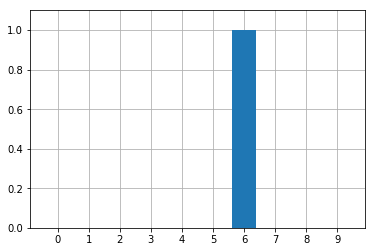

In [26]:
import random

random.seed(10)
np.set_printoptions(precision=2, suppress=True, linewidth=60)
robo_filter(4, kernel=[1.], sensor_accuracy=.999,
             move_distance=4, do_print=True)

Die Simulation oben dient dazu, die  Klasse ``RoboCar`` und die Funktion ``robo_filter()`` zu testen:  
Die Sollgeschwindigkeit ist 4 pro Sekunde, der Abweichung der Ist-Bewegung ist 0 und der Abstandssensor liefert zu 99,9 % fehlerfreie Messwerte - Ideale Bedingungen also.  
Der Flur ist kreisförmig und im obigen Beispiel 10 Positionen lang: Daher kommt nach Position 8 und einer Bewegung von 4 Schritten wieder die Position 2. Die Schätzwerte entsprechen alle den wahren Positionen, und es verwundert nicht, dass die Konfidenz schnell 100 % groß wird.  

Der Code funktioniert also einwandfrei. Als nächstes wird eine Simulation mit immer noch idealem Sensor aber merklichen Bewegungsabweichungen ausgeführt.

Zeit 0: wahre Pos. 4, Pos.Vorh. 4, Pos.-Messw. 4, Pos.-Schätzw. 4, Konfidenz 98.8621 %
Zeit 1: wahre Pos. 8, Pos.Vorh. 8, Pos.-Messw. 8, Pos.-Schätzw. 8, Konfidenz 99.1057 %
Zeit 2: wahre Pos. 2, Pos.Vorh. 2, Pos.-Messw. 2, Pos.-Schätzw. 2, Konfidenz 99.1126 %
Zeit 3: wahre Pos. 6, Pos.Vorh. 6, Pos.-Messw. 6, Pos.-Schätzw. 6, Konfidenz 99.1128 %
Zeit 4: wahre Pos. 0, Pos.Vorh. 0, Pos.-Messw. 0, Pos.-Schätzw. 0, Konfidenz 99.1128 %
Zeit 5: wahre Pos. 4, Pos.Vorh. 4, Pos.-Messw. 4, Pos.-Schätzw. 4, Konfidenz 99.1128 %
Zeit 6: wahre Pos. 9, Pos.Vorh. 8, Pos.-Messw. 9, Pos.-Schätzw. 9, Konfidenz 89.7613 %
Zeit 7: wahre Pos. 4, Pos.Vorh. 3, Pos.-Messw. 4, Pos.-Schätzw. 4, Konfidenz 88.4094 %
Zeit 8: wahre Pos. 8, Pos.Vorh. 8, Pos.-Messw. 8, Pos.-Schätzw. 8, Konfidenz 98.8244 %
Zeit 9: wahre Pos. 2, Pos.Vorh. 2, Pos.-Messw. 2, Pos.-Schätzw. 2, Konfidenz 99.1055 %
Zeit 10: wahre Pos. 6, Pos.Vorh. 6, Pos.-Messw. 6, Pos.-Schätzw. 6, Konfidenz 99.1126 %
Zeit 11: wahre Pos. 9, Pos.Vorh. 0, Pos.-M

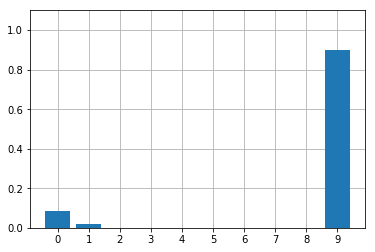

In [27]:
random.seed(10)
robo_filter(12, kernel=[.15, .7, .15], sensor_accuracy=.98,
         move_distance=4, do_print=True)

In dem Fall oben ist die Messabweichung des Sensors sehr gering, jedoch liegt die Vorhersage manchmal daneben, wenn die tatsächliche Schrittweite von ``move_distance`` abweicht, wie z.B. zur Zeit 6. Dies bewirkt einen vorrübergehenden moderaten Einbruch der Konfidenz.

Es folgt eine Simulation mit geringer Bewegungsunsicherheit aber recht großer Messabweichung.

Zeit 0: wahre Pos. 4, Pos.Vorh. 4, Pos.-Messw. 4, Pos.-Schätzw. 4, Konfidenz 95.3803 %
Zeit 1: wahre Pos. 8, Pos.Vorh. 8, Pos.-Messw. 8, Pos.-Schätzw. 8, Konfidenz 97.0361 %
Zeit 2: wahre Pos. 2, Pos.Vorh. 2, Pos.-Messw. 3, Pos.-Schätzw. 2, Konfidenz 88.0445 %
Zeit 3: wahre Pos. 6, Pos.Vorh. 6, Pos.-Messw. 6, Pos.-Schätzw. 6, Konfidenz 94.3388 %
Zeit 4: wahre Pos. 0, Pos.Vorh. 0, Pos.-Messw. 0, Pos.-Schätzw. 0, Konfidenz 96.6838 %
Zeit 5: wahre Pos. 4, Pos.Vorh. 4, Pos.-Messw. 3, Pos.-Schätzw. 4, Konfidenz 87.4311 %
Zeit 6: wahre Pos. 8, Pos.Vorh. 8, Pos.-Messw. 8, Pos.-Schätzw. 8, Konfidenz 94.1052 %
Zeit 7: wahre Pos. 2, Pos.Vorh. 2, Pos.-Messw. 2, Pos.-Schätzw. 2, Konfidenz 96.6023 %
Zeit 8: wahre Pos. 6, Pos.Vorh. 6, Pos.-Messw. 6, Pos.-Schätzw. 6, Konfidenz 97.4805 %
Zeit 9: wahre Pos. 0, Pos.Vorh. 0, Pos.-Messw. 0, Pos.-Schätzw. 0, Konfidenz 97.7827 %
Zeit 10: wahre Pos. 4, Pos.Vorh. 4, Pos.-Messw. 5, Pos.-Schätzw. 4, Konfidenz 88.6530 %
Zeit 11: wahre Pos. 8, Pos.Vorh. 8, Pos.-M

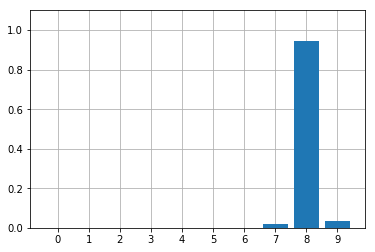

In [28]:
random.seed(10)
robo_filter(12, kernel=[.02, .96, .02], sensor_accuracy=.75,
         move_distance=4, do_print=True)

Die Vorhersage liegt nie daneben. Jedoch sinkt die Konfidenz der geschätzten Position nach einem Ausreißer des Abstandssensors deutlich ab, wie z.B. zur Zeit 5. Dies heilt nach einigen Schritten ohne Ausreißer aber wieder aus.

Die nächste Simulation besitzt sowohl für die Bewegungsunsicherheit als auch für die Messunsicherheit große Werte.

Zeit 0: wahre Pos. 4, Pos.Vorh. 4, Pos.-Messw. 4, Pos.-Schätzw. 4, Konfidenz 84.1755 %
Zeit 1: wahre Pos. 8, Pos.Vorh. 8, Pos.-Messw. 8, Pos.-Schätzw. 8, Konfidenz 82.3295 %
Zeit 2: wahre Pos. 2, Pos.Vorh. 2, Pos.-Messw. 3, Pos.-Schätzw. 2, Konfidenz 44.1766 %
Zeit 3: wahre Pos. 6, Pos.Vorh. 6, Pos.-Messw. 6, Pos.-Schätzw. 6, Konfidenz 65.5570 %
Zeit 4: wahre Pos. 0, Pos.Vorh. 0, Pos.-Messw. 0, Pos.-Schätzw. 0, Konfidenz 75.1121 %
Zeit 5: wahre Pos. 5, Pos.Vorh. 4, Pos.-Messw. 4, Pos.-Schätzw. 4, Konfidenz 78.9778 %
Zeit 6: wahre Pos. 0, Pos.Vorh. 8, Pos.-Messw. 0, Pos.-Schätzw. 8, Konfidenz 54.9246 %
Zeit 7: wahre Pos. 4, Pos.Vorh. 2, Pos.-Messw. 4, Pos.-Schätzw. 2, Konfidenz 37.4931 %
Zeit 8: wahre Pos. 8, Pos.Vorh. 6, Pos.-Messw. 8, Pos.-Schätzw. 8, Konfidenz 39.3592 %
Zeit 9: wahre Pos. 2, Pos.Vorh. 2, Pos.-Messw. 2, Pos.-Schätzw. 2, Konfidenz 56.7531 %
Zeit 10: wahre Pos. 5, Pos.Vorh. 6, Pos.-Messw. 6, Pos.-Schätzw. 6, Konfidenz 68.8410 %
Zeit 11: wahre Pos. 0, Pos.Vorh. 0, Pos.-M

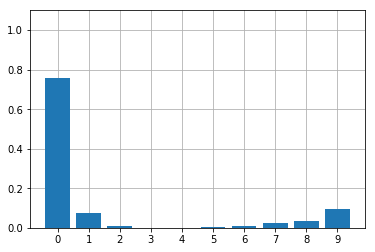

In [29]:
random.seed(10)
robo_filter(12, kernel=[.15, .70, .15], sensor_accuracy=.75,
         move_distance=4, do_print=True)

In dem Worst Case Beispiel oben ist schön zu sehen, dass der Filter sich immer wieder fängt, falls man ein Ausreißer im Messwert oder in der Schrittanzahl zugeschlagen hat.

Im abschließenden Code werden sehr viele Iterationen ausgefürt, wovon neun aufeinanderfolgende als Histogramme dargestellt werden.  
*Achtung*: Die Ausführung dieses Codes dauert ein wenig länger als gewöhnt.

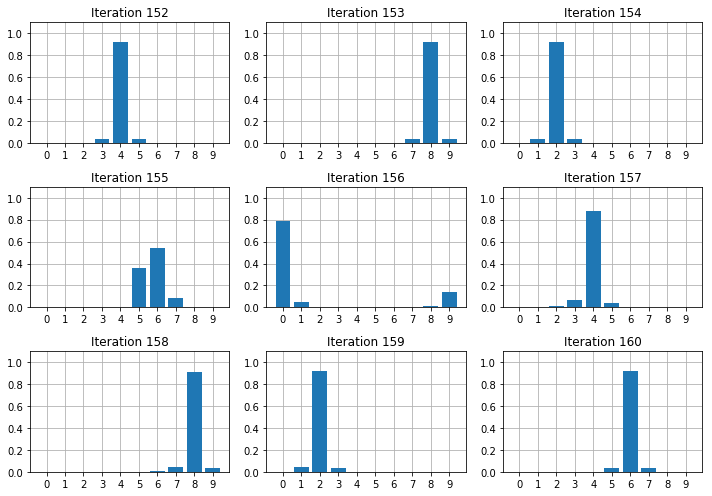

In [30]:
plt.figure(figsize=(10, 7)) # figure size
for i in range (9):
    random.seed(3)    
    plt.subplot(3,3,1+i) # 3x3 plots in figure, 1+i is number of active plot
    robo_filter(152+i, kernel=[.1, .8, .1], sensor_accuracy=.8, move_distance=4, do_print=False)
    plt.title ('Iteration {}'.format(152+i))
    plt.tight_layout()

Es ist gut sichtbar, wie die Position sich von Iteration zu Iteration um 4 Schritte ändert. Das Roboterfahrzeug währt also immer im Kreis.  
Bei Iteration 155 sinkt auf einmal die Konfidenz auf unter 60 % ab. Aber bei Iteration 159 ist die Wahrscheinlickeitsdichte der Position wieder angewachen auf das vorherige Niveau von ca. 85 %.  
Es gibt also immer wieder mal Einbrüche der Konfidenz - entweder durch einen falschen Messwert oder durch eine falsche Vorhersage.

## Keine Angst vor dem Bayes Theorem
Am besten löst man ein Problem zunächst hemdsärmelig mit viel Intuition und gesundem Menschenverstand. Erst danach sollte man sich Gedanken über die Theorie dazu machen. Diesem Leitbild folgt dieses Notebook. Bisher sind noch keine Theoreme oder komlizierten Matrizengleichungen aufgetaucht. Zum Glück.  

Denn viele Lehrbücher zum Kalman-Filter gehen genau den umgekehrten Weg: Sie knallen dem Leser erst die Theorie vor den Latz und präsentieren anschließend - wenn überhaupt - einige wenige Anwendungsbeispiele dazu. Ein solches Vorgehen wird an Hochschule zumal auch als "Forschung" beschrieben. Aber auch an Gymnasien ist diese Pseudowissenschaftlichkeit oft zu finden, wenn die Lehrer sich für Fachwissenschaftler und nicht für Pädagogen halten. Genug gelästert.   

Die statistischen Betrachtungen im bisherigen Verlauf dieses Notebooks mündeten in die beiden zentralen Filterfunktionen ``predict()`` und ``update()``.

Der Funktion `update()` liegt folgende zentrale Berechnung zugrunde:

$$\mathtt{Posterior} = \frac{\mathtt{Likelihood} \times \mathtt{Prior}}{\mathtt{Normierung}}$$ 

**Der *prior* ist eine Wahrscheinlichkeitsverteilung, die auf einer Vorhersage basiert, dem sogenannte *Vorhersagewert*. Die Messung liefert eine Annahme (engl. *Likelihood*) über den Zustand, mit der der Prior korrigiert und daraus der Korrekturwert *Posterior* berechnet wird. Der Posterior ist der Schätzwert zur Wahrscheinlichkeitsverteilung, den der Filter schließlich ausgibt.**

Das Bayes-Theorem lautet:

$$P(A \mid B) = \frac{P(B \mid A)\, P(A)}{P(B)}$$

*Wieder liegt der Hase in der Notation und in den Begrifflichkeiten begraben:*  
$P(A)$ steht für die Eintrittswahrscheinlichkeit eines Ereignisses $A$. Wenn $A$ z.B. das Ergeinis "Zahl" bei einem Münzenwur ist, dann wäre $P(A) = 0.5$, also 50 %.

**Definition: $P(A \mid B)$ nennt man "bedingte Wahrscheinlichkeit". Damit ist die Wahrscheinlichkeit gemeint für das Eintreten von Ereignis $A$ *wenn* gleichzeitig auch Ereignis $B$ eintritt.**  
Zum Beispiel ist das Ereignis "Regen" heute wahrscheinlicher, wenn es gestern auch schon geregnet hat. Die bedingte Wahrscheinlichkeit für heutigen Regen bei gleichzeitig gestrigen Regen würde also mit $P(\mathtt{Heute\_Regen} \mid \mathtt{Gestern\_Regen})$ ausgedrückt werden.

In der Gleichung des Bayes-Theorems oben ist $B$ is die "*Evidenz*", $P(A)$ ist der *Prior*, $P(B \mid A)$ ist die *Likelihood* und $P(A \mid B)$ ist der *Posterior*. Wie gleich gezeigt wird, ist dies identisch zu der hier entwickelten Funktion ``update()``:  
Dafür muss die Gleichung etwas umgeschrieben werden. $x_i$ steht für die Position mit Index *i* im Array der Wahrscheinlichkeitsdichte und $z$ für den Positionsmesswert. **Aufgabe der Funkton ``update()`` ist es $P(x_i \mid Z)$ zu berechnen: Die Wahrscheinlichkeit der Position $x_i$ unter Berücksichtigung des Messwerts $z$.** 

Also gilt nach dem Bayes-Theorem:

$$P(x_i \mid z) = \frac{P(z \mid x_i) P(x_i)}{P(z)}$$

$P(x_i)$ ist der Prior, also die Wahrscheinlichkeit für die Position i nach der Vorhersage. Im Beispiel des Roboterfahrzeugs bedeutet beispielsweise $i = 4$ die Position 4, also vor der Türe 4. $P(x_4)$ ist dann die Wahrscheinlichkeit, dass sich das Fahrzeug an Position 4 befindet.  

$P(z \mid x_i)$ ist die bedingte Wahrscheinlichkeit für einen Messwert $z$, wenn sich das Fahrzeug an der Position i befindet: Befindet sich das Fahrzeug beispielsweise an Position 4 mit $sensor\_accuracy = 0,75$ und $z = 4$, dann beträgt diese 75 %. Führt man dies für jeden Index des Arrays durch, so erhält man am Ende einen Array, wo in jedem Element die Wahrscheinlichkeit für die entsprechende Position *aufgrund des Messwerts $z$ steht*.   
Dies ist eine unnormierte Annahme der Position (Wahrscheinlichkeitsdichteverteilung) aufgrund der Messung - **dies ist die Likelihood**.

$ P(z \mid x_i) P(x_i)$ ist identisch zur Multiplikation ``likelihood * prior`` in der ``update()``-Funktion:

```python
def update(likelihood, prior):
    posterior = (likelihood * prior)/sum(likelihood * prior)
    return (posterior)
```

$P(z)$ ist die Wahrscheinlichkeit unabhängig von der tatsächlichen Position, den Messwert $z$ zu erhalten. Durch die Division mit $P(z)$ wird der Term des Bayes-Theorems rechts neben dem Gleichheitszeichen normiert. Das dem tatsächlich so ist, ist gar nicht so einfach zu erkennen. Und tatsächlich liegt beim Bayes-Theorem im Term $P(z)$ oft der Hase begraben.   

**Die ``update()``-Funktion ist also identisch zum Bayes-Theorem:  
Links steht der Korrekturwert (Posterior) und rechts die Berechnungsformel ${(\mathtt{Likelihood} \times \mathtt{Prior}})/{\mathtt{Normierung}}$**

In der Literator taucht das Bayes-Theorem auch in Form von Integralen, also für eine kontinuierliche und nicht wie hier diskrete Berechnung. Also keine Angst, wenn in einem Lehrbuch folgendes Theorem abgebildet ist:

$$P(A \mid B) = \frac{P(B \mid A)\, P(A)}{\int P(B \mid A_j) P(A_j) \mathtt{d}A_j}\cdot$$ 
Dies ist nur die analoge Version des digitalen Bayestheorems von ganz oben.  

Damit wäre die Theorie rund um die ``update()``-Funktion abgefrühstückt. Es bleibt noch die Theorie zur ``predict()``-Funktion.

## Keine Angst vor dem Satz / Gesetz der totalen Wahrscheinlichkeit
Die Funktion ``update()`` gehört zum Korrekturschritt des g-h-Filters und basiert auf dem Bayes-Theorem wie oben dargestellt.  
Die Funktion ``predict()`` gehört zum Vorhersageschritt des g-h-Filters, und kann ebenso theoretisch untermauert werden: *Hiefür ist das "Gesetz bzw. der Satz der totalen Wahrscheinlichkeit" zuständig.*  

Die Funktion ``predict()`` berechnet die Wahrscheinlichkeitsdichte für den nächsten Zeitpunkt, indem für jedes Element (Position) des Posteriors jede mögliche Propagation (Bewegung) durchgespielt wird. Für jede Ausgangsposition gibt es dadurch eine Verteilung von Positionen zum nächsten Zeitpunkt. Die Wahrscheinlichkeiten all dieser Verteilungen werden getrennt für jeden Index aufaddiert und bilden damit den neuen Prior.  

Mathematisch formuliert, sieht das so aus:
* Die Wahrscheinlichkeit, dass sich das Roboterfahrzeug zur aktuellen Zeit $t$ an der Position $X_i$ befindet, beträgt $P(X_i^t)$. 
* Die Wahrscheinlichkeit, dass es sich zum Zeitpunkt $t-1$ davor an der Position $X_j$ befunden hatte, beträgt $P(X_j^{t-1})$.
* Die Wahrscheinlichkeit, dass es sich in der Zeit dazwischen von der Position $X_j$ auf die Position $X_i$ bewegt hat, beträgt $P(X_i | X_j)$.   

Da das Fahrzeug über viele mögliche Bewegungen zur Position $X_i$ gelangt sein kann, muss man die Wahrscheinlichkeiten der möglichen Wege aufaddieren: 

$$P(X_i^t) = \sum_j P(X_j^{t-1})  P(X_i | X_j)$$

Diese Gleichung ist nichts Anderes als das *"Gesetz bzw. der Satz der totalen Wahrscheinlichkeit"*. 
Ein Blick auf den Quellcodeausschnitt der Funktion ``predict_move()`` zeigt, dass hier genau die gleiche Berechnung durchgeführt wird. Hier werden nur die drei möglichen Bewegungen "Ein Schritt vor", "Ein Schritt zurück" und "Stillstand" betrachtet.

```python
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)
```
In der finalen Vorhersagefunktion ``predict()`` sind Bewegungen über beliebig viele Schritt möglich. Das Aufsummieren übernimmt hier die Faltungsoperation.

## Zusammenfassung
Der Quellcode für die beiden Kernalgorithem Vorhersage und Korrektur ist sehr kurz aber mächtig. Er bildet den Kern des hier vorgestellten Bayes-Filters.  
Die Beispiele zeigen eindrücklich, wie ohne Startinformationen trotz stark verrauschter Messdaten die Position des Roboterfahrzeugs nach einigen Filteriterationen mit > 80 % Vertrauensniveau geschätzt wird.  
Der Vorhersageschritt hat meistens das Vertrauensniveau etwas vermindert. Aber die anschließende Messung, egal wie verrauscht sie war, konnte über den Korrekturschritt das Vertrauensniveau wieder erhöhen.  

Die bisherigen Inhalte dienen alle der Vorbereitung auf den Kalman-Filter. Dieser verwendet zwar eine andere mathematische Berechnung, **die zugrunde liegende Logik ist aber identisch zum Bayes-Filter**: 
> Es werden mit Hilfe des Bayes-Theorems Schätzwerte aus mit Messwerten korrigierten Vorhersagewerten berechnet. Grob gesagt bewirkt die Vorhersage das Verschieben und die Korrektur eine Multiplikation der Wahrscheinlichkeitsverteilung. Wobei die Wahrscheinlickheitsverteilung den geschätzen Zustandswert repräsentiert.  

**Das Verständnis der o.g. grundlegenden Gedanken ist absolut nötig, um den Kalman-Filter im letzten Notebook zu verstehen.**

## Literaturverweise

 * [1] D. Fox, W. Burgard, and S. Thrun. "Monte carlo localization: Efficient position estimation for mobile robots." In *Journal of Artifical Intelligence Research*, 1999.
 
 http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume11/fox99a-html/jair-localize.html


 * [2] Dieter Fox, et. al. "Bayesian Filters for Location Estimation". In *IEEE Pervasive Computing*, September 2003.
 
 http://swarmlab.unimaas.nl/wp-content/uploads/2012/07/fox2003bayesian.pdf
 
 
 * [3] Sebastian Thrun. "Artificial Intelligence for Robotics".
 
 https://www.udacity.com/course/cs373